**Métodos Numéricos III, Edgar Moyotl\-Hernández, FCFM\-BUAP, 2023**

## Proyecto final ML

**Nombre**: Rasshid Ortiz Rodríguez

**Matrícula**: 202049989

#  Análisis y Agrupamiento de Equipos de Fútbol

## Introducción
El fútbol es el deporte más popular en todo el mundo, y analizar el rendimiento de los equipos puede proporcionar información valiosa sobre su estilo de juego y éxito en las ligas. En este proyecto, utilizaremos técnicas de aprendizaje no supervisado para analizar y agrupar equipos del fútbol europeo basándonos en diversas características, con el objetivo de descubrir patrones interesantes y obtener una comprensión más profunda del mundo del fútbol.Nos interesan especialmente las ligas europeas ya que estadísticamente es el continente con más nivel en sus equipos, mayor popularidad y que más dinero invierte en este deporte. Tan solo en 2022  el conjunto de competiciones incrementó sus ingresos un 7% hasta alcanzar los 29.500 millones de euros




ligas.avif

## Objetivo
El objetivo principal de este proyecto es aplicar técnicas de aprendizaje no supervisado, específicamente el algoritmo K-Means y K-Means++, para agrupar los 299 equipos del fútbol europeo en función de su rendimiento en diferentes aspectos del juego, esto para intentar hacer ligas más competitivas y así aumentar la popularidad y evitar que los ganadores sean los equipos de siempre. Además, buscamos identificar patrones emergentes y proporcionar una visión más completa de las dinámicas presentes en el fútbol.

## Conjunto de datos



Utilizaremos el conjunto de datos "European Soccer Database" extraído de la plataforma Kaggle, que contiene información detallada sobre equipos, jugadores, partidos y ligas con infromación de  octubre del 2016. Este conjunto de datos proporcionará las características necesarias para realizar nuestro análisis. También importaremos nuestro módulo propio llamado ML (Machine Learning) el cual nos permitirá hacer uso de los modelos a probar. Esto sumado a libreías como Pandas nos serán  de utilidad para el análisis.

In [1]:
# Importar modulo propio
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/modulos')
import ML
# Importar librerias necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random as rd
import numpy.random as nrd
import math

Mounted at /content/drive


El siguiente código muestra como podemos subir un archivo .zip y descomprimirlo.

In [2]:
# Subir el archivo ZIP al entorno de Google Colab
from google.colab import files
# Subir el archivo ZIP con el nombre "archive"
uploaded = files.upload()
# Descomprimir el archivo ZIP
import zipfile
import os
# Nombre del archivo ZIP subido
zip_filename = 'archive.zip'
# Carpeta de destino para extraer los archivos
extract_folder = '/content/soccer_dataset'
# Descomprimir el archivo ZIP
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)
# Mostrar la lista de archivos en la carpeta extraída
os.listdir(extract_folder)

Saving archive.zip to archive.zip


['database.sqlite']

Para cargar nuestro conjunto de datos nos quedaremos con la información que necesitamos, es decir, crearemos nuestro data frame considerando las siguientes características para los equipos:
+ Promedio de goles por partido
+ Promedio de goles en contra por partido
+ Promedio de la diferencia de goles por partido
+ Promedio de los puntos obtenidos en sus respectivas ligas por partido
+ Tasas de victorias
+ Tasa de derrotas
+ Tasa de empates \\
Esto porque las ligas en el fútbol toman todo esto en cuenta para determinar a los ganadores de sus respectivas ligas así como los equipos que descienden por temporada. Consideramos el promedio porque no todos los equipos han jugado el mismo número de partidos.

In [24]:
# cargar conjunto de datos
import sqlite3
database_path = os.path.join(extract_folder, 'database.sqlite')
conn = sqlite3.connect(database_path)
# Agregar al data frame las características seleccionadas
query = """
    SELECT Team.team_long_name, Team.team_api_id,
           AVG(CASE WHEN Match.home_team_api_id = Team.team_api_id THEN Match.home_team_goal + Match.away_team_goal
                    WHEN Match.away_team_api_id = Team.team_api_id THEN Match.away_team_goal + Match.home_team_goal
                    ELSE 0 END) as avg_goals,
           AVG(CASE WHEN Match.home_team_api_id = Team.team_api_id THEN Match.away_team_goal
                    WHEN Match.away_team_api_id = Team.team_api_id THEN Match.home_team_goal
                    ELSE 0 END) as avg_goals_conceded,
           AVG(CASE WHEN Match.home_team_api_id = Team.team_api_id THEN Match.home_team_goal - Match.away_team_goal
                    WHEN Match.away_team_api_id = Team.team_api_id THEN Match.away_team_goal - Match.home_team_goal
                    ELSE 0 END) as goal_difference_avg,
           AVG(CASE WHEN Match.home_team_api_id = Team.team_api_id AND Match.home_team_goal > Match.away_team_goal THEN 3
                    WHEN Match.away_team_api_id = Team.team_api_id AND Match.away_team_goal > Match.home_team_goal THEN 3
                    WHEN (Match.home_team_api_id = Team.team_api_id OR Match.away_team_api_id = Team.team_api_id) AND Match.home_team_goal = Match.away_team_goal THEN 1
                    ELSE 0 END) as total_points_avg,
           AVG(CASE WHEN Match.home_team_api_id = Team.team_api_id AND Match.home_team_goal > Match.away_team_goal THEN 1
                    WHEN Match.away_team_api_id = Team.team_api_id AND Match.away_team_goal > Match.home_team_goal THEN 1
                    ELSE 0 END) as win_percentage,
           AVG(CASE WHEN Match.home_team_api_id = Team.team_api_id AND Match.home_team_goal < Match.away_team_goal THEN 1
                    WHEN Match.away_team_api_id = Team.team_api_id AND Match.away_team_goal < Match.home_team_goal THEN 1
                    ELSE 0 END) as loss_percentage,
           AVG(CASE WHEN Match.home_team_goal = Match.away_team_goal THEN 1 ELSE 0 END) as draw_percentage
    FROM Team
    JOIN Match ON Team.team_api_id = Match.home_team_api_id OR Team.team_api_id = Match.away_team_api_id
    GROUP BY Team.team_long_name, Team.team_api_id
"""

# Crear el DataFrame con las características mencionadas
df_teams = pd.read_sql_query(query, conn)

# Reorganizar el orden de las columnas
df_teams = df_teams[['team_long_name', 'team_api_id', 'avg_goals', 'avg_goals_conceded', 'goal_difference_avg', 'total_points_avg', 'win_percentage', 'loss_percentage', 'draw_percentage']]

# Visualizar las primeras filas del DataFrame
df_teams.head(20)

,team_long_name,team_api_id,avg_goals,avg_goals_conceded,goal_difference_avg,total_points_avg,win_percentage,loss_percentage,draw_percentage
0,1. FC Kaiserslautern,8350,2.602941,1.544118,-0.485294,1.014706,0.250000,0.485294,0.264706
1,1. FC Köln,8722,2.632353,1.524510,-0.416667,1.147059,0.294118,0.441176,0.264706
2,1. FC Nürnberg,8165,2.717647,1.582353,-0.447059,1.117647,0.288235,0.458824,0.252941
3,1. FSV Mainz 05,9905,2.684874,1.340336,0.004202,1.382353,0.369748,0.357143,0.273109
4,AC Ajaccio,8576,2.631579,1.614035,-0.596491,0.929825,0.192982,0.456140,0.350877
5,AC Arles-Avignon,108893,2.394737,1.842105,-1.289474,0.526316,0.078947,0.631579,0.289474
6,AC Bellinzona,6493,3.203704,2.018519,-0.833333,0.925926,0.231481,0.537037,0.231481
7,ADO Den Haag,10217,3.066176,1.720588,-0.375000,1.143382,0.290441,0.437500,0.272059
8,AJ Auxerre,8583,2.171053,1.065789,0.039474,1.375000,0.348684,0.322368,0.328947
9,AS Monaco,9829,2.298246,1.039474,0.219298,1.578947,0.416667,0.254386,0.328947


## Análisis descriptivo y exploratorio de los datos

En este apartado vamos a explorar y analizar nuestro data frame, para que una vez sepamos lo más relevante de él, podamos efectuar una limpieza de los datos.

In [18]:
#Mostrar la columna de goles promedio por cada equipo
df_teams.avg_goals

0      2.602941
1      2.632353
2      2.717647
3      2.684874
4      2.631579
         ...   
294    2.736842
295    2.438889
296    2.733333
297    2.638158
298    2.520833
Name: avg_goals, Length: 299, dtype: float64

Esto nos proporciona información importante por cada columna del data frame.

In [20]:
# Estadísticas descriptivas del data frame
print("\nEstadísticas descriptivas:")
print(df_teams.describe())


Estadísticas descriptivas:
         team_api_id   avg_goals  avg_goals_conceded  goal_difference_avg  \
count     299.000000  299.000000          299.000000           299.000000   
mean    12340.521739    2.678256            1.444912            -0.211567   
std     25940.411135    0.289769            0.290647             0.575348   
min      1601.000000    2.013158            0.649194            -1.529412   
25%      8349.000000    2.474342            1.272446            -0.581140   
50%      8655.000000    2.639860            1.433333            -0.309211   
75%      9886.500000    2.855263            1.631579             0.024187   
max    274581.000000    3.773026            2.264706             2.029605   

       total_points_avg  win_percentage  loss_percentage  draw_percentage  
count        299.000000      299.000000       299.000000       299.000000  
mean           1.231828        0.325681         0.419535         0.254784  
std            0.368931        0.127333         0.

En la siguiente celda  podemos asegurar que no hay datos nulos o vacíos en nuestro data frame, así como el tipo de dato que maneja cada columna.

In [21]:
# Análisis exploratorio de los datos
print("Información general del conjunto de datos:")
print(df_teams.info())

Información general del conjunto de datos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   team_long_name       299 non-null    object 
 1   team_api_id          299 non-null    int64  
 2   avg_goals            299 non-null    float64
 3   avg_goals_conceded   299 non-null    float64
 4   goal_difference_avg  299 non-null    float64
 5   total_points_avg     299 non-null    float64
 6   win_percentage       299 non-null    float64
 7   loss_percentage      299 non-null    float64
 8   draw_percentage      299 non-null    float64
dtypes: float64(7), int64(1), object(1)
memory usage: 21.1+ KB
None


También es importante observar si hay correlaciones en las variables, que es lo que haremos a continuación.

In [26]:
#Obtener coeficientes de correlación
df_teams.corr()

<ipython-input-26-c204d1792e51>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_teams.corr()


,team_api_id,avg_goals,avg_goals_conceded,goal_difference_avg,total_points_avg,win_percentage,loss_percentage,draw_percentage
team_api_id,1.000000,-0.041169,0.051159,-0.072422,-0.095447,-0.093295,0.095693,0.009332
avg_goals,-0.041169,1.000000,0.269658,0.231196,0.276681,0.322363,-0.166929,-0.462199
avg_goals_conceded,0.051159,0.269658,1.000000,-0.874523,-0.834757,-0.801156,0.868358,-0.042266
goal_difference_avg,-0.072422,0.231196,-0.874523,1.000000,0.982731,0.971790,-0.961404,-0.190079
total_points_avg,-0.095447,0.276681,-0.834757,0.982731,1.000000,0.993236,-0.969003,-0.230034
win_percentage,-0.093295,0.322363,-0.801156,0.971790,0.993236,1.000000,-0.933762,-0.341481
loss_percentage,0.095693,-0.166929,0.868358,-0.961404,-0.969003,-0.933762,1.000000,-0.017520
draw_percentage,0.009332,-0.462199,-0.042266,-0.190079,-0.230034,-0.341481,-0.017520,1.000000


<ipython-input-27-91ff49e32af0>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_teams.corr(), annot=True)


<Axes: >

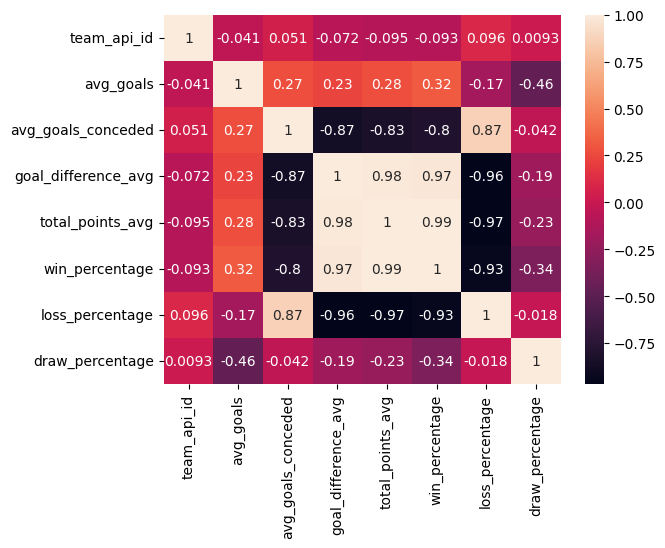

In [27]:
# Mapa de calor para visualizar la correlación
sns.heatmap(df_teams.corr(), annot=True)

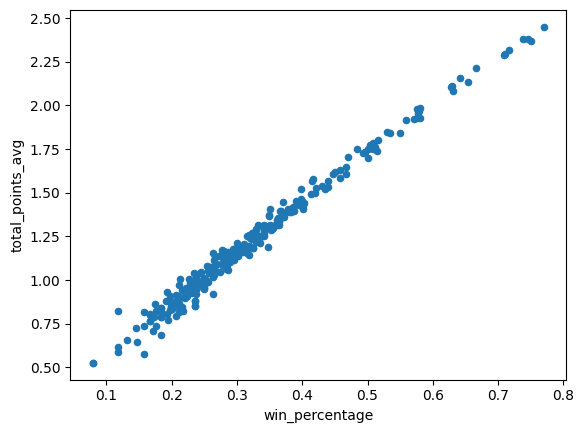

In [28]:
# Gràfica de una alta correlación positiva entre nuestras variables win_percentage y total_points_avg
df_teams.plot(kind = 'scatter', x = 'win_percentage', y = 'total_points_avg')
plt.show()

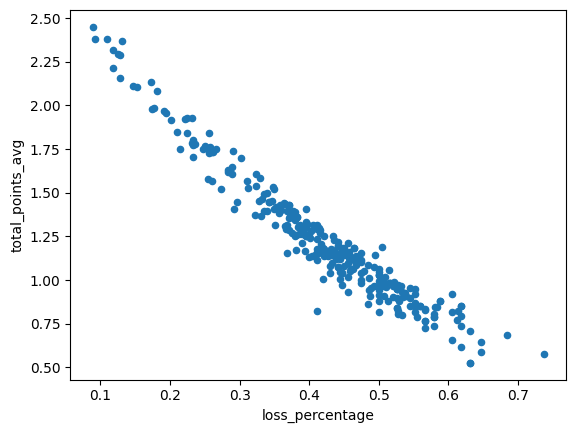

In [30]:
# Gràfica de una alta correlación negativa entre nuestras variables loss_percentage y total_points_avg
df_teams.plot(kind = 'scatter', x = 'loss_percentage', y = 'total_points_avg')
plt.show()

Dado que hay variables altamente correlacionadas y para que nuestro modelo sea más eficiente y menos redundante eliminaremos algunas características (las de mayor correlación ya sea positiva o negativa). Este proceso lo haremos en la limpieza de datos.

#### Histogramas
Aquí podemos visualizar la frecuencia de cada característica

<Axes: >

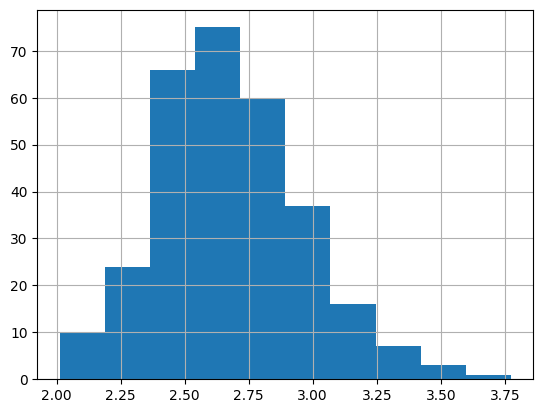

In [32]:
#Histograma del promedio de los goles en casa
df_teams["avg_goals"].hist()

<Axes: >

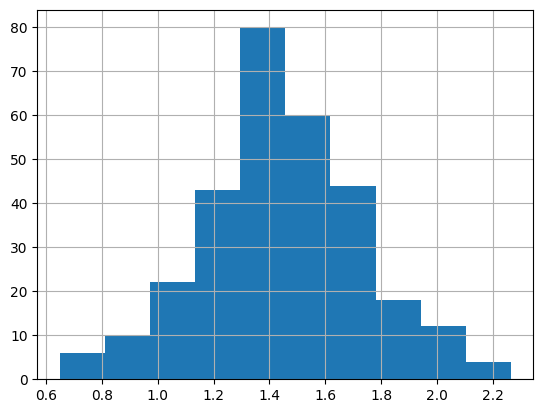

In [33]:
#Histograma del promedio de los goles en contra
df_teams["avg_goals_conceded"].hist()

<Axes: >

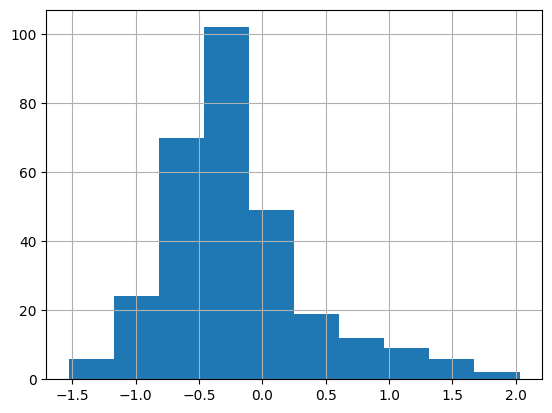

In [34]:
#Histograma del promedio de la diferencia de goles
df_teams["goal_difference_avg"].hist()

<Axes: >

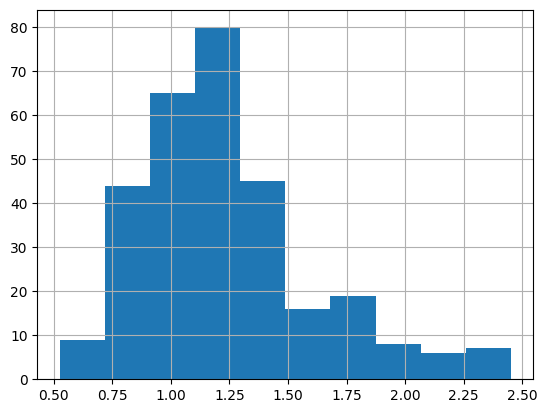

In [35]:
# Histograma de los puntos promedio
df_teams["total_points_avg"].hist()

<Axes: >

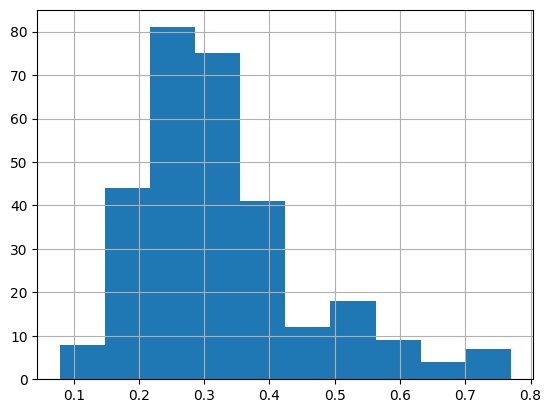

In [36]:
#Histograma de la tasa de victorias
df_teams["win_percentage"].hist()

<Axes: >

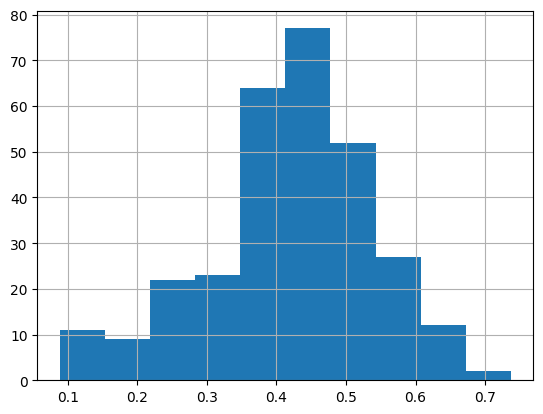

In [37]:
#histograma de la tasa de derrotas
df_teams["loss_percentage"].hist()

<Axes: >

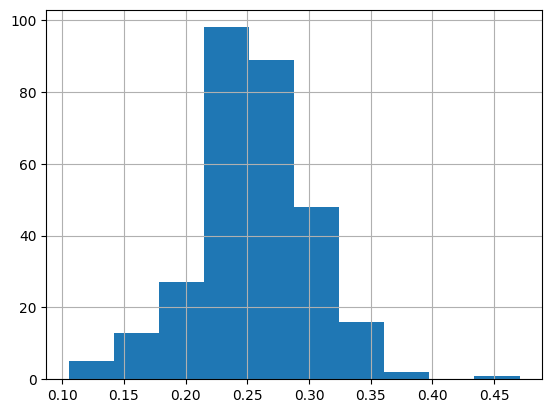

In [38]:
#Histograma de la tasa de empates
df_teams["draw_percentage"].hist()

#### **Gráfico de dispersión entre columnas**

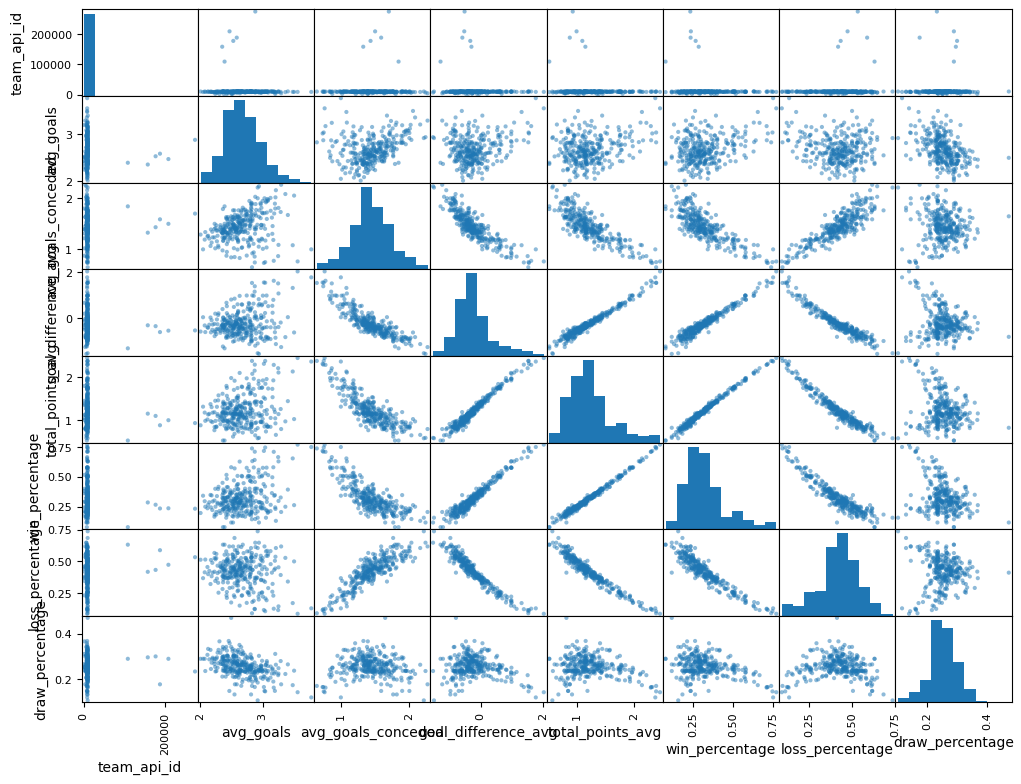

In [39]:
# Gráfico de dispersión entre columnas
axes = pd.plotting.scatter_matrix(df_teams, figsize=(12,9))

#### Visualización de la distribución de características

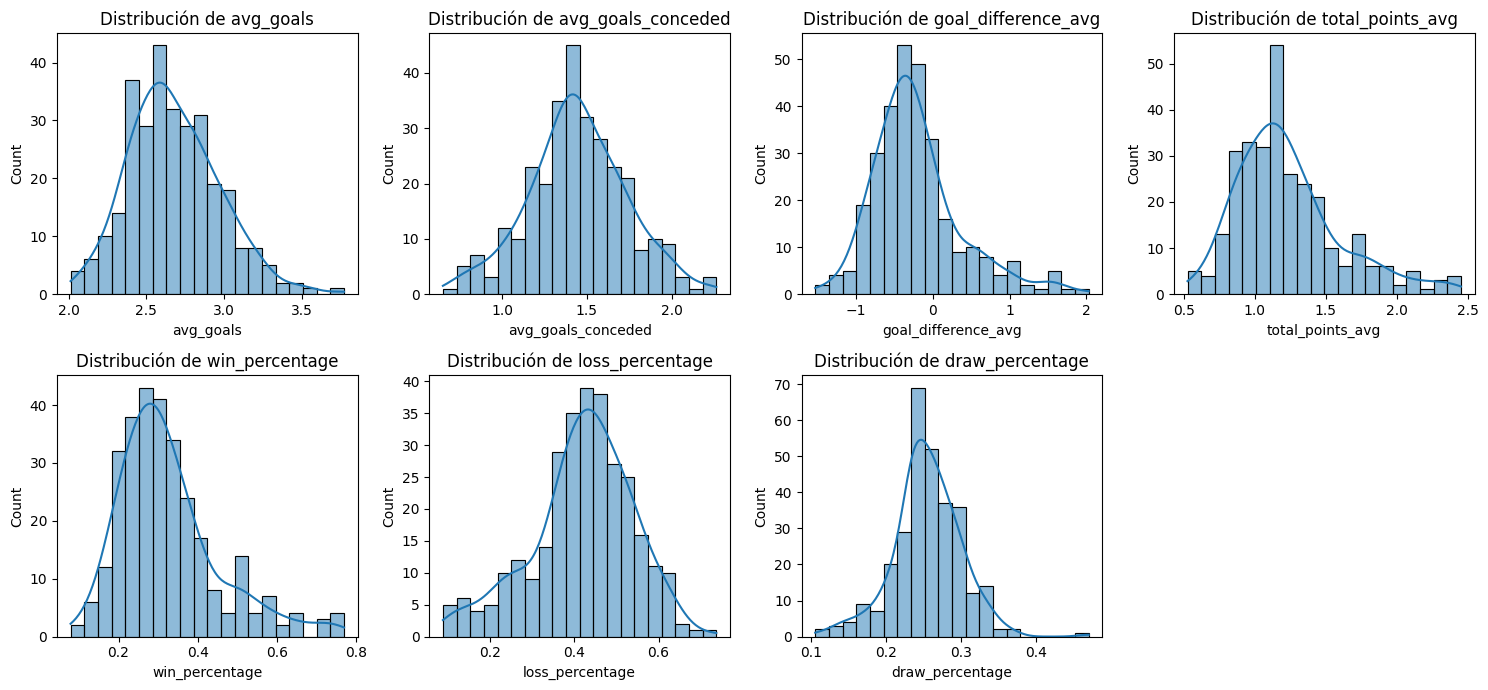

In [48]:
# Visualización de la distribución de características
features_to_plot = ['avg_goals', 'avg_goals_conceded', 'goal_difference_avg', 'total_points_avg', 'win_percentage', 'loss_percentage', 'draw_percentage']

plt.figure(figsize=(15, 7))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(2, 4, i)
    sns.histplot(df_teams[feature], bins=20, kde=True)
    plt.title(f'Distribución de {feature}')
plt.tight_layout()
plt.show()

## Limpieza de datos

Como vimos anteriormente vamos a eliminar algunas características redundantes para nuestro data frame, esto es, las variables con demasiada correlación, esto nos dará mejores resultados en nuestro modelo. Además dado que no contiene datos nulos nuestro data frame y debido a que para nuestra clasificación no consideraremos la característica de la columna "team_api_id", es decir, vamos a reducir esa columna del data frame, entonces solo queda revisar si existen valores atípicos o también llamados outliers en nuestro data. Para ello tenemos una función que detecta y remplaza un valor atípico de alguna columna de nuestro data frame. Aunque se enunciará un ejemplo, en realidad no cambiaremos ningún valor del data ya que por la bibliografía no hay ningún error en la recopilación de estos datos, puesto que ya se hizo previamente la detección de estos outliers.

#### Detección de outliers usando cuartiles

A continuación viene un ejemplo de como detectar y reemplazar outliers. Para ello usaremos una función propia llamada "drop_outliers".

In [49]:
# Función para detectar y reemplazar ouliers
def drop_outliers2(df, column):
  # obtener cuartil superior e inferior
  q75, q25 =np.percentile(df[column], [75, 25])
  #rango intercuartìlico
  S=1.5*(q75-q25)
  # calcular el umbral superior e inferior
  UmbSup= q75+S
  UmbInf= q25-S
  #obtener mediana
  med= df[column].median()
  #reemplazar por la mediana los valores atipicos
  for x in df.index:
    if (df.loc[x, column] > UmbSup) or (df.loc[x, column] < UmbInf):
      df.loc[x, column]=med
  #regresar el data frame
  return df

En el análisis exploratorio observamos que para la columna "total_points_avg" el valor máximo era $2.450658$ veamos si se remplaza algún valor de esa columna.

In [51]:
#buscar valores atípicos y reemplazarlos
new_df=drop_outliers2(df_teams, "total_points_avg")
new_df.head(20)

,team_long_name,team_api_id,avg_goals,avg_goals_conceded,goal_difference_avg,total_points_avg,win_percentage,loss_percentage,draw_percentage
0,1. FC Kaiserslautern,8350,2.602941,1.544118,-0.485294,1.014706,0.250000,0.485294,0.264706
1,1. FC Köln,8722,2.632353,1.524510,-0.416667,1.147059,0.294118,0.441176,0.264706
2,1. FC Nürnberg,8165,2.717647,1.582353,-0.447059,1.117647,0.288235,0.458824,0.252941
3,1. FSV Mainz 05,9905,2.684874,1.340336,0.004202,1.382353,0.369748,0.357143,0.273109
4,AC Ajaccio,8576,2.631579,1.614035,-0.596491,0.929825,0.192982,0.456140,0.350877
5,AC Arles-Avignon,108893,2.394737,1.842105,-1.289474,0.526316,0.078947,0.631579,0.289474
6,AC Bellinzona,6493,3.203704,2.018519,-0.833333,0.925926,0.231481,0.537037,0.231481
7,ADO Den Haag,10217,3.066176,1.720588,-0.375000,1.143382,0.290441,0.437500,0.272059
8,AJ Auxerre,8583,2.171053,1.065789,0.039474,1.375000,0.348684,0.322368,0.328947
9,AS Monaco,9829,2.298246,1.039474,0.219298,1.578947,0.416667,0.254386,0.328947


Contabilizar valores reemplazados.

In [52]:
#Construir vector booleano
y=[new_df["total_points_avg"]==df_teams["total_points_avg"]]
#Contar datos no reemplazados
Contador=np.count_nonzero(y)
print("Los datos no reemplazados son ", Contador, "/ 299")

Los datos no reemplazados son  299 / 299


Podemos hacer eso para todas las características, sin embargo en este data set sabemos de ante mano que no hay valores atípicos. Pero este es un ejemplo de como detectarlos, contarlos y además reemplazarlos.

Ahora eliminemos las columnas innecesarias y además redundantes.

In [29]:
df_teams_new=df_teams.drop([df_teams.columns[0],df_teams.columns[1],df_teams.columns[4], df_teams.columns[5]],1)
df_teams_new.head()

<ipython-input-29-86ac09b68894>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_teams_new=df_teams.drop([df_teams.columns[0],df_teams.columns[1],df_teams.columns[4], df_teams.columns[5]],1)


,avg_goals,avg_goals_conceded,win_percentage,loss_percentage,draw_percentage
0,2.602941,1.544118,0.250000,0.485294,0.264706
1,2.632353,1.524510,0.294118,0.441176,0.264706
2,2.717647,1.582353,0.288235,0.458824,0.252941
3,2.684874,1.340336,0.369748,0.357143,0.273109
4,2.631579,1.614035,0.192982,0.456140,0.350877


<Axes: >

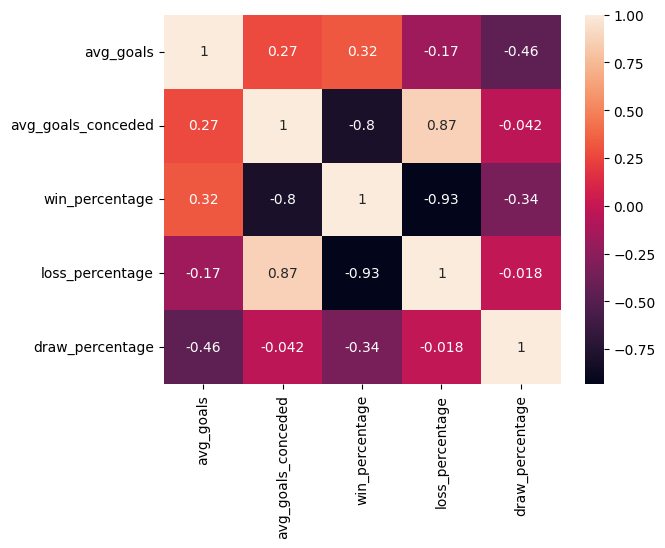

In [80]:
# Mapa de calor para visualizar la nueva correlación
sns.heatmap(df_teams_new.corr(), annot=True)

## Preparación de los datos

In [30]:
# Extraer valores para la matriz X
X = df_teams_new.values[:,0:6]
X

array([[2.60294118, 1.54411765, 0.25      , 0.48529412, 0.26470588],
       [2.63235294, 1.5245098 , 0.29411765, 0.44117647, 0.26470588],
       [2.71764706, 1.58235294, 0.28823529, 0.45882353, 0.25294118],
       ...,
       [2.73333333, 1.48333333, 0.31666667, 0.45      , 0.23333333],
       [2.63815789, 1.45394737, 0.29605263, 0.46710526, 0.23684211],
       [2.52083333, 1.19583333, 0.37083333, 0.29583333, 0.33333333]])

Aquí es importante mencionar que como nuestro análisis se basa en el promedio de cada característica por partido, los datos están en la misma escala, sin embargo en otro caso es necesario realizar un proceso de normalización de los datos, el siguiente código es un ejemplo de ello.  

In [83]:
from sklearn.preprocessing import StandardScaler
# Normalizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[-0.26034833,  0.34190138, -0.59535474,  0.55030098,  0.2180572 ],
       [-0.15867734,  0.27432544, -0.24829949,  0.18110628,  0.2180572 ],
       [ 0.13616852,  0.47367448, -0.29457352,  0.32878416, -0.04049303],
       ...,
       [ 0.19039304,  0.13241595, -0.07091569,  0.25494522, -0.47141008],
       [-0.1386107 ,  0.03114095, -0.23307776,  0.39808913, -0.39429861],
       [-0.54417983, -0.85841636,  0.35519103, -1.03518515,  1.72626686]])

## Construcción del modelo


 Primero utilizaremos los métodos del codo y silueta para determinar el $k$ óptimo de agrupamiento, esperando que este valor sea cercano a  $11$ pues al final no planeamos hacer un cambio en el número de ligas. Utilizaremos el algoritmo  K-means para hacer el agrupamiento de equipos, luego lo compararemos con otros equipos de su misma etiqueta para ver que tan equilibradas están las ligas respecto a los equipos que tienen. Finalmente evaluaremos el modelo con un análisis estadístico de algunos grupos (en este caso los grupos son las nuevas ligas).

Veamos los resultados del $k$ óptimo para el método del codo seleccionando como límite de clusters $N=20$.

[59.91585318 38.23318285 23.66816159 20.33978691 15.97824045 13.90315515
 11.98465638 11.13555829  9.98437769  9.0697102   8.30907949  8.03747638
  7.20744772  7.17263675  6.19838132  6.4927313   5.47748906  5.72118697
  4.84211859  5.29147762]


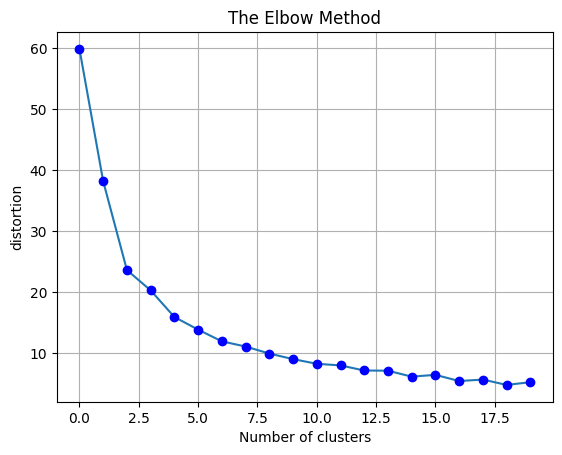

In [88]:
#Definir limite
N_clusters=20
#Calcular inercia
inercia=ML.elbow(X, N_clusters)
print(inercia)
# Gráfica del codo
plt.plot(range(0, N_clusters), inercia)
plt.plot(range(0, N_clusters), inercia,"bo")
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('distortion')
plt.grid()
plt.show()

Método de la silueta

[0.33344961 0.40578985 0.34444585 0.33121572 0.29971224 0.27467688
 0.29376927 0.2733614  0.28158084 0.30454035 0.2928461  0.27788147
 0.27827836 0.26656512 0.27524705 0.28168192 0.28331557 0.29660426
 0.28214149]


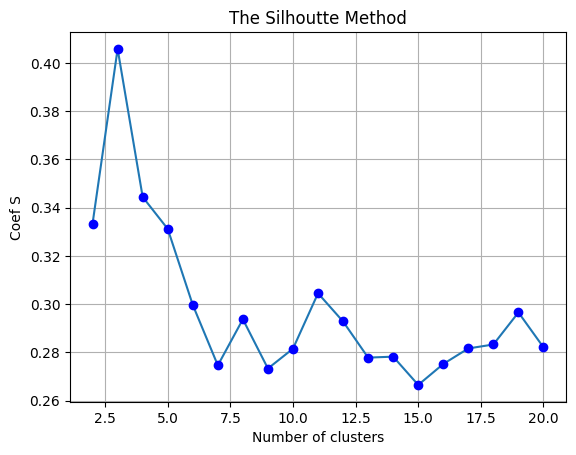

In [89]:
#Definir limite
N_clusters=20
#Calcular coeficientes de silueta
CoefSilueta=ML.silhouette(X,N_clusters)
print(CoefSilueta)
# Gráfica del método de la sulueta
plt.plot(range(2, N_clusters+1), CoefSilueta)
plt.plot(range(2, N_clusters+1), CoefSilueta,"bo")
plt.title('The Silhoutte Method')
plt.xlabel('Number of clusters')
plt.ylabel('Coef S')
plt.grid()
plt.show()

Aunque ambos métodos indican que el $k$ óptimo es menor a $5$ intentaremos  formar $11$ grupos para que haya la posibilidad de mantener todas las ligas. Esto porque si  hiciéramos menos ligas no daría tiempo a jugar todos los partidos y terminaría en un desastre.

## Entrenamiento del modelo

In [48]:
# construir modelo
y_pred=ML.k_means_Criterio_1(X,11)
y_pred

iteraciones 23


array([ 8, 10,  3, 10,  8,  8,  7,  9,  1,  1,  4,  1,  2,  1,  4,  0,  6,
        1,  6,  5, 10,  4, 10,  5,  2,  4,  5,  3,  4,  3,  7,  6,  4,  3,
        0,  2,  9,  6,  9,  4, 10,  9,  7,  4, 10, 10,  9,  8,  4,  0,  8,
        5,  6,  0, 10,  4,  8,  8,  9,  8,  3,  2,  7,  9,  8,  3,  6,  4,
        4, 10,  5,  7,  9,  4, 10,  0,  0,  0,  7,  8,  2,  6,  8, 10,  2,
        8,  6, 10,  9,  0,  5, 10,  4,  3,  7, 10,  5,  2,  9,  7,  2,  9,
        6,  8,  5,  5,  9,  9, 10,  8,  1, 10, 10,  8,  1,  9,  8,  2,  6,
        4,  3,  4,  9,  4,  9,  7, 10, 10,  8,  8,  5, 10,  4,  5,  5,  8,
        5,  3,  9,  4,  2,  2,  3,  8, 10,  4,  1, 10,  8,  8,  3,  1,  4,
        5,  5,  6, 10,  8,  5,  9,  7,  5,  5,  6,  5,  1,  8,  2, 10,  3,
        3,  5,  6,  3,  3,  3,  9,  4,  6,  5,  1,  7,  1,  2,  0,  3,  5,
       10, 10,  7,  4, 10,  4,  4,  4,  8,  8,  9,  7, 10, 10,  4,  8, 10,
       10,  9,  5, 10,  0,  7,  7,  3,  0,  2,  3,  3,  8,  8,  6,  7,  5,
        3, 10,  9,  4,  6

Como nuestras predicciones de agrupamiento son para ligas con etiquetas numéricas haremos dos cosas, la primera es obtener la información de las ligas, es decir, encontrar la liga correspondiente de cada equipo para posteriormente hacer un mapeado donde cada número corresponda a una liga mediante un diccionario.

In [32]:
#Información  para obtener las ligas
query = """
    SELECT DISTINCT Team.team_api_id, League.name as league_name
    FROM Team
    JOIN Match ON Team.team_api_id = Match.home_team_api_id OR Team.team_api_id = Match.away_team_api_id
    JOIN League ON Match.league_id = League.id
"""
# Leer la información de la base de datos
df_labels = pd.read_sql_query(query, conn)
# Mostrar las primeras filas del DataFrame con información de etiquetas
df_labels.head()

,team_api_id,league_name
0,9987,Belgium Jupiler League
1,9993,Belgium Jupiler League
2,9994,Belgium Jupiler League
3,10000,Belgium Jupiler League
4,8635,Belgium Jupiler League


In [33]:
# Mapeo de nombres de liga a etiquetas numéricas
league_mapping = {name: idx for idx, name in enumerate(df_labels['league_name'].unique())}
# Crear una nueva columna 'league_label' con etiquetas numéricas
df_labels['league_label'] = df_labels['league_name'].map(league_mapping)
# Obtener un vector de etiquetas no ordenadas
labels = df_labels['league_label'].values
# Mostrar las primeras filas del DataFrame con información de etiquetas
df_labels.head(10)

,team_api_id,league_name,league_label
0,9987,Belgium Jupiler League,0
1,9993,Belgium Jupiler League,0
2,9994,Belgium Jupiler League,0
3,10000,Belgium Jupiler League,0
4,8635,Belgium Jupiler League,0
5,9984,Belgium Jupiler League,0
6,9991,Belgium Jupiler League,0
7,9998,Belgium Jupiler League,0
8,7947,Belgium Jupiler League,0
9,9985,Belgium Jupiler League,0


Ahora haremos el mapeado para ordenar las etiquetas en el orden de nuestro data frame original

In [34]:
#Mapeado de etiquetas al mismo orden del data frame df_teams
n=len(df_labels["team_api_id"])
etiquetas=np.zeros(n)
for i in range (n):
  for j in range (n):
    if (df_teams["team_api_id"][i]==df_labels["team_api_id"][j]):
      etiquetas[i]=df_labels["league_label"][j]

In [35]:
#vector de etiquetas reales y ordenadas
etiquetas

array([ 3.,  3.,  3.,  3.,  2.,  2., 10.,  5.,  2.,  2.,  2.,  2.,  5.,
        8.,  7.,  5.,  7.,  2.,  6.,  1.,  1.,  4.,  9.,  9., 10.,  4.,
        3.,  0.,  1.,  1.,  1.,  7.,  4.,  1.,  3.,  3.,  1.,  4.,  1.,
        9.,  7.,  9.,  9.,  7.,  7.,  4.,  1.,  4.,  4.,  8.,  4.,  1.,
        4.,  0.,  6.,  1.,  9.,  3.,  5.,  2.,  8.,  8.,  8.,  2.,  3.,
        3.,  9.,  4.,  2.,  7.,  1.,  5., 10.,  7.,  3.,  9., 10.,  3.,
        5.,  3.,  5.,  3., 10.,  2., 10.,  2.,  2.,  7.,  7.,  7.,  3.,
       10.,  2., 10.,  3., 10.,  5.,  5., 10.,  5., 10.,  0.,  8.,  7.,
        5.,  4.,  3.,  4.,  1.,  2.,  6.,  4.,  9.,  7.,  2.,  5.,  9.,
       10.,  2.,  6.,  3.,  8.,  3.,  8.,  4.,  5.,  3.,  8.,  1.,  9.,
        4.,  8.,  6.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        3.,  8.,  6.,  2.,  4.,  2.,  2.,  4.,  6.,  6.,  6.,  1.,  7.,
        9.,  0.,  1.,  4., 10.,  1.,  1.,  1.,  4.,  2.,  7.,  8.,  9.,
        5.,  5.,  4.,  7., 10.,  1.,  1.,  4.,  2.,  6.,  2.,  2

Ahora creamos nuestro diccionario para decodificar las etiquetas numéricas con sus respectivas ligas

In [ ]:
#diccionario de las ligas
mapeo_ligas = {0: 'Belgium Jupiler League', 1: 'England Premier League', 2: 'France Ligue 1',
               3: "Germany 1. Bundesliga",4: "Italy Serie A",5: "Netherlands Eredivisie", 6:"Poland Ekstraklasa", 7:"Portugal Liga ZON Sagres",
               8:"Scotland Premier League",9:"Spain LIGA BBVA", 10: "Switzerland Super League"}
# Decodificación de números de etiqueta a nombres de ligas del vector de etiquetas original
nombres_ligas = [mapeo_ligas[num] for num in etiquetas]
nombres_ligas

In [ ]:
#ligas para las etiquetas predichas
nombres_ligas_new = [mapeo_ligas[num] for num in y_pred]
nombres_ligas_new

In [51]:
#Mostrar predicciones
df_teams['liga_predicha'] = nombres_ligas_new
df_teams.head(20)

,team_long_name,team_api_id,avg_goals,avg_goals_conceded,goal_difference_avg,total_points_avg,win_percentage,loss_percentage,draw_percentage,liga_predicha
0,1. FC Kaiserslautern,8350,2.602941,1.544118,-0.485294,1.014706,0.250000,0.485294,0.264706,Scotland Premier League
1,1. FC Köln,8722,2.632353,1.524510,-0.416667,1.147059,0.294118,0.441176,0.264706,Switzerland Super League
2,1. FC Nürnberg,8165,2.717647,1.582353,-0.447059,1.117647,0.288235,0.458824,0.252941,Germany 1. Bundesliga
3,1. FSV Mainz 05,9905,2.684874,1.340336,0.004202,1.382353,0.369748,0.357143,0.273109,Switzerland Super League
4,AC Ajaccio,8576,2.631579,1.614035,-0.596491,0.929825,0.192982,0.456140,0.350877,Scotland Premier League
5,AC Arles-Avignon,108893,2.394737,1.842105,-1.289474,0.526316,0.078947,0.631579,0.289474,Scotland Premier League
6,AC Bellinzona,6493,3.203704,2.018519,-0.833333,0.925926,0.231481,0.537037,0.231481,Portugal Liga ZON Sagres
7,ADO Den Haag,10217,3.066176,1.720588,-0.375000,1.143382,0.290441,0.437500,0.272059,Spain LIGA BBVA
8,AJ Auxerre,8583,2.171053,1.065789,0.039474,1.375000,0.348684,0.322368,0.328947,England Premier League
9,AS Monaco,9829,2.298246,1.039474,0.219298,1.578947,0.416667,0.254386,0.328947,England Premier League


In [ ]:
df_teams.to_markdown()

## Nueva asignación de los equipos a las ligas en base a su rendimiento

|     | team_long_name               |   team_api_id |   avg_goals |   avg_goals_conceded |   goal_difference_avg |   total_points_avg |   win_percentage |   loss_percentage |   draw_percentage | liga_predicha            |
|----:|:-----------------------------|--------------:|------------:|---------------------:|----------------------:|-------------------:|-----------------:|------------------:|------------------:|:-------------------------|
|   0 | 1. FC Kaiserslautern         |          8350 |     2.60294 |             1.54412  |           -0.485294   |           1.01471  |        0.25      |         0.485294  |          0.264706 | Scotland Premier League  |
|   1 | 1. FC Köln                   |          8722 |     2.63235 |             1.52451  |           -0.416667   |           1.14706  |        0.294118  |         0.441176  |          0.264706 | Switzerland Super League |
|   2 | 1. FC Nürnberg               |          8165 |     2.71765 |             1.58235  |           -0.447059   |           1.11765  |        0.288235  |         0.458824  |          0.252941 | Germany 1. Bundesliga    |
|   3 | 1. FSV Mainz 05              |          9905 |     2.68487 |             1.34034  |            0.00420168 |           1.38235  |        0.369748  |         0.357143  |          0.273109 | Switzerland Super League |
|   4 | AC Ajaccio                   |          8576 |     2.63158 |             1.61404  |           -0.596491   |           0.929825 |        0.192982  |         0.45614   |          0.350877 | Scotland Premier League  |
|   5 | AC Arles-Avignon             |        108893 |     2.39474 |             1.84211  |           -1.28947    |           0.526316 |        0.0789474 |         0.631579  |          0.289474 | Scotland Premier League  |
|   6 | AC Bellinzona                |          6493 |     3.2037  |             2.01852  |           -0.833333   |           0.925926 |        0.231481  |         0.537037  |          0.231481 | Portugal Liga ZON Sagres |
|   7 | ADO Den Haag                 |         10217 |     3.06618 |             1.72059  |           -0.375      |           1.14338  |        0.290441  |         0.4375    |          0.272059 | Spain LIGA BBVA          |
|   8 | AJ Auxerre                   |          8583 |     2.17105 |             1.06579  |            0.0394737  |           1.375    |        0.348684  |         0.322368  |          0.328947 | England Premier League   |
|   9 | AS Monaco                    |          9829 |     2.29825 |             1.03947  |            0.219298   |           1.57895  |        0.416667  |         0.254386  |          0.328947 | England Premier League   |
|  10 | AS Nancy-Lorraine            |          8481 |     2.40526 |             1.33684  |           -0.268421   |           1.16316  |        0.294737  |         0.426316  |          0.278947 | Italy Serie A            |
|  11 | AS Saint-Étienne             |          9853 |     2.29276 |             1.07237  |            0.148026   |           1.46382  |        0.398026  |         0.332237  |          0.269737 | England Premier League   |
|  12 | AZ                           |         10229 |     3.08824 |             1.27941  |            0.529412   |           1.73897  |        0.514706  |         0.290441  |          0.194853 | France Ligue 1           |
|  13 | Aberdeen                     |          8485 |     2.375   |             1.17434  |            0.0263158  |           1.43092  |        0.394737  |         0.358553  |          0.246711 | England Premier League   |
|  14 | Académica de Coimbra         |         10215 |     2.3629  |             1.39516  |           -0.427419   |           1.00806  |        0.225806  |         0.443548  |          0.330645 | Italy Serie A            |
|  15 | Ajax                         |          8593 |     3.24632 |             0.867647 |            1.51103    |           2.21324  |        0.665441  |         0.117647  |          0.216912 | Belgium Jupiler League   |
|  16 | Amadora                      |         10213 |     2.13333 |             1.26667  |           -0.4        |           1.13333  |        0.266667  |         0.4       |          0.333333 | Poland Ekstraklasa       |
|  17 | Angers SCO                   |          8121 |     2.05263 |             1        |            0.0526316  |           1.31579  |        0.342105  |         0.368421  |          0.289474 | England Premier League   |
|  18 | Arka Gdynia                  |          8322 |     2.2     |             1.34444  |           -0.488889   |           0.955556 |        0.222222  |         0.488889  |          0.288889 | Poland Ekstraklasa       |
|  19 | Arsenal                      |          9825 |     2.9375  |             1.05263  |            0.832237   |           1.91776  |        0.559211  |         0.200658  |          0.240132 | Netherlands Eredivisie   |
|  20 | Aston Villa                  |         10252 |     2.62171 |             1.51974  |           -0.417763   |           1.13816  |        0.282895  |         0.427632  |          0.289474 | Switzerland Super League |
|  21 | Atalanta                     |          8524 |     2.41445 |             1.3384   |           -0.262357   |           1.1635   |        0.30038   |         0.437262  |          0.262357 | Italy Serie A            |
|  22 | Athletic Club de Bilbao      |          8315 |     2.72039 |             1.35526  |            0.00986842 |           1.4375   |        0.401316  |         0.365132  |          0.233553 | Switzerland Super League |
|  23 | Atlético Madrid              |          9906 |     2.77961 |             1.05592  |            0.667763   |           1.84211  |        0.549342  |         0.256579  |          0.194079 | Netherlands Eredivisie   |
|  24 | BSC Young Boys               |         10192 |     3.15385 |             1.3042   |            0.545455   |           1.73077  |        0.496503  |         0.262238  |          0.241259 | France Ligue 1           |
|  25 | Bari                         |          9976 |     2.38158 |             1.38158  |           -0.381579   |           0.973684 |        0.236842  |         0.5       |          0.263158 | Italy Serie A            |
|  26 | Bayer 04 Leverkusen          |          8178 |     2.98529 |             1.20956  |            0.566176   |           1.75368  |        0.503676  |         0.253676  |          0.242647 | Netherlands Eredivisie   |
|  27 | Beerschot AC                 |          9993 |     2.70395 |             1.55921  |           -0.414474   |           1.06579  |        0.263158  |         0.460526  |          0.276316 | Germany 1. Bundesliga    |
|  28 | Birmingham City              |          8658 |     2.36842 |             1.38158  |           -0.394737   |           1.17105  |        0.276316  |         0.381579  |          0.342105 | Italy Serie A            |
|  29 | Blackburn Rovers             |          8655 |     2.80921 |             1.65789  |           -0.506579   |           1.08553  |        0.276316  |         0.467105  |          0.256579 | Germany 1. Bundesliga    |
|  30 | Blackpool                    |          8483 |     3.5     |             2.05263  |           -0.605263   |           1.02632  |        0.263158  |         0.5       |          0.236842 | Portugal Liga ZON Sagres |
|  31 | Boavista FC                  |          8613 |     2.08824 |             1.33824  |           -0.588235   |           0.985294 |        0.25      |         0.514706  |          0.235294 | Poland Ekstraklasa       |
|  32 | Bologna                      |          9857 |     2.38783 |             1.38783  |           -0.387833   |           1.07605  |        0.258555  |         0.441065  |          0.30038  | Italy Serie A            |
|  33 | Bolton Wanderers             |          8559 |     2.85526 |             1.66447  |           -0.473684   |           1.06579  |        0.282895  |         0.5       |          0.217105 | Germany 1. Bundesliga    |
|  34 | Borussia Dortmund            |          9789 |     3.0625  |             1.03676  |            0.988971   |           1.95956  |        0.577206  |         0.194853  |          0.227941 | Belgium Jupiler League   |
|  35 | Borussia Mönchengladbach     |          9788 |     2.875   |             1.39338  |            0.0882353  |           1.43015  |        0.400735  |         0.371324  |          0.227941 | France Ligue 1           |
|  36 | Bournemouth                  |          8678 |     2.94737 |             1.76316  |           -0.578947   |           1.10526  |        0.289474  |         0.473684  |          0.236842 | Spain LIGA BBVA          |
|  37 | Brescia                      |          9858 |     2.26316 |             1.36842  |           -0.473684   |           0.842105 |        0.184211  |         0.526316  |          0.289474 | Poland Ekstraklasa       |
|  38 | Burnley                      |          8191 |     2.69737 |             1.77632  |           -0.855263   |           0.828947 |        0.197368  |         0.565789  |          0.236842 | Spain LIGA BBVA          |
|  39 | CA Osasuna                   |          8371 |     2.38596 |             1.36842  |           -0.350877   |           1.16228  |        0.29386   |         0.425439  |          0.280702 | Italy Serie A            |
|  40 | CD Nacional                  |         10214 |     2.72984 |             1.39113  |           -0.0524194  |           1.39919  |        0.379032  |         0.358871  |          0.262097 | Switzerland Super League |
|  41 | CD Numancia                  |          8388 |     2.81579 |             1.81579  |           -0.815789   |           0.921053 |        0.263158  |         0.605263  |          0.131579 | Spain LIGA BBVA          |
|  42 | CD Tenerife                  |          9867 |     3       |             1.94737  |           -0.894737   |           0.947368 |        0.236842  |         0.526316  |          0.236842 | Portugal Liga ZON Sagres |
|  43 | CF Os Belenenses             |          9807 |     2.39241 |             1.4557   |           -0.518987   |           1.03797  |        0.234177  |         0.43038   |          0.335443 | Italy Serie A            |
|  44 | CS Marítimo                  |         10212 |     2.66935 |             1.39516  |           -0.120968   |           1.29435  |        0.342742  |         0.391129  |          0.266129 | Switzerland Super League |
|  45 | Cagliari                     |          8529 |     2.60227 |             1.43182  |           -0.261364   |           1.14394  |        0.287879  |         0.431818  |          0.280303 | Switzerland Super League |
|  46 | Cardiff City                 |          8344 |     2.78947 |             1.94737  |           -1.10526    |           0.789474 |        0.184211  |         0.578947  |          0.236842 | Spain LIGA BBVA          |
|  47 | Carpi                        |        208931 |     2.47368 |             1.5      |           -0.526316   |           1        |        0.236842  |         0.473684  |          0.289474 | Scotland Premier League  |
|  48 | Catania                      |          8530 |     2.49554 |             1.375    |           -0.254464   |           1.17857  |        0.299107  |         0.419643  |          0.28125  | Italy Serie A            |
|  49 | Celtic                       |          9925 |     3.01974 |             0.733553 |            1.55263    |           2.31579  |        0.717105  |         0.118421  |          0.164474 | Belgium Jupiler League   |
|  50 | Cesena                       |          9880 |     2.51818 |             1.62727  |           -0.736364   |           0.790909 |        0.172727  |         0.554545  |          0.272727 | Scotland Premier League  |
|  51 | Chelsea                      |          8455 |     2.85855 |             0.940789 |            0.976974   |           1.96711  |        0.578947  |         0.190789  |          0.230263 | Netherlands Eredivisie   |
|  52 | Chievo Verona                |          8533 |     2.15182 |             1.21122  |           -0.270627   |           1.14851  |        0.287129  |         0.425743  |          0.287129 | Poland Ekstraklasa       |
|  53 | Club Brugge KV               |          8342 |     3.16981 |             1.18396  |            0.801887   |           1.92925  |        0.580189  |         0.231132  |          0.188679 | Belgium Jupiler League   |
|  54 | Cracovia                     |          2186 |     2.51429 |             1.39524  |           -0.27619    |           1.12381  |        0.290476  |         0.457143  |          0.252381 | Switzerland Super League |
|  55 | Crystal Palace               |          9826 |     2.35965 |             1.31579  |           -0.27193    |           1.18421  |        0.324561  |         0.464912  |          0.210526 | Italy Serie A            |
|  56 | Córdoba CF                   |          7869 |     2.36842 |             1.78947  |           -1.21053    |           0.526316 |        0.0789474 |         0.631579  |          0.289474 | Scotland Premier League  |
|  57 | DSC Arminia Bielefeld        |          9912 |     2.5     |             1.64706  |           -0.794118   |           0.823529 |        0.117647  |         0.411765  |          0.470588 | Scotland Premier League  |
|  58 | De Graafschap                |          8526 |     2.82353 |             1.86765  |           -0.911765   |           0.845588 |        0.198529  |         0.551471  |          0.25     | Spain LIGA BBVA          |
|  59 | Dijon FCO                    |          9836 |     2.65789 |             1.65789  |           -0.657895   |           0.947368 |        0.236842  |         0.526316  |          0.236842 | Scotland Premier League  |
|  60 | Dundee FC                    |          8284 |     2.69298 |             1.57895  |           -0.464912   |           1.07895  |        0.254386  |         0.429825  |          0.315789 | Germany 1. Bundesliga    |
|  61 | Dundee United                |          9938 |     2.87171 |             1.43092  |            0.00986842 |           1.40789  |        0.378289  |         0.348684  |          0.273026 | France Ligue 1           |
|  62 | Dunfermline Athletic         |          8457 |     3.21053 |             2.15789  |           -1.10526    |           0.657895 |        0.131579  |         0.605263  |          0.263158 | Portugal Liga ZON Sagres |
|  63 | ES Troyes AC                 |         10242 |     2.82895 |             1.89474  |           -0.960526   |           0.723684 |        0.144737  |         0.565789  |          0.289474 | Spain LIGA BBVA          |
|  64 | Eintracht Braunschweig       |          9776 |     2.61765 |             1.76471  |           -0.911765   |           0.735294 |        0.176471  |         0.617647  |          0.205882 | Scotland Premier League  |
|  65 | Eintracht Frankfurt          |          9810 |     2.84034 |             1.59664  |           -0.352941   |           1.17227  |        0.302521  |         0.432773  |          0.264706 | Germany 1. Bundesliga    |
|  66 | Elche CF                     |         10268 |     2.32895 |             1.47368  |           -0.618421   |           1.06579  |        0.263158  |         0.460526  |          0.276316 | Poland Ekstraklasa       |
|  67 | Empoli                       |          8534 |     2.46053 |             1.32895  |           -0.197368   |           1.15789  |        0.263158  |         0.368421  |          0.368421 | Italy Serie A            |
|  68 | En Avant de Guingamp         |          9747 |     2.41228 |             1.34211  |           -0.27193    |           1.18421  |        0.324561  |         0.464912  |          0.210526 | Italy Serie A            |
|  69 | Estoril Praia                |          7842 |     2.55469 |             1.25     |            0.0546875  |           1.45312  |        0.390625  |         0.328125  |          0.28125  | Switzerland Super League |
|  70 | Everton                      |          8668 |     2.61184 |             1.16776  |            0.276316   |           1.52303  |        0.398026  |         0.273026  |          0.328947 | Netherlands Eredivisie   |
|  71 | Excelsior                    |         10218 |     3.08088 |             1.94853  |           -0.816176   |           0.852941 |        0.198529  |         0.544118  |          0.257353 | Portugal Liga ZON Sagres |
|  72 | FC Aarau                     |          9930 |     2.96528 |             1.90278  |           -0.840278   |           0.965278 |        0.243056  |         0.520833  |          0.236111 | Spain LIGA BBVA          |
|  73 | FC Arouca                    |        158085 |     2.35714 |             1.32653  |           -0.295918   |           1.15306  |        0.285714  |         0.418367  |          0.295918 | Italy Serie A            |
|  74 | FC Augsburg                  |          8406 |     2.60588 |             1.42353  |           -0.241176   |           1.23529  |        0.323529  |         0.411765  |          0.264706 | Switzerland Super League |
|  75 | FC Barcelona                 |          8634 |     3.55592 |             0.763158 |            2.02961    |           2.45066  |        0.769737  |         0.0888158 |          0.141447 | Belgium Jupiler League   |
|  76 | FC Basel                     |          9931 |     3.25175 |             1.08741  |            1.07692    |           2.11189  |        0.629371  |         0.146853  |          0.223776 | Belgium Jupiler League   |
|  77 | FC Bayern Munich             |          9823 |     3.17647 |             0.775735 |            1.625      |           2.29044  |        0.709559  |         0.128676  |          0.161765 | Belgium Jupiler League   |
|  78 | FC Dordrecht                 |          6631 |     2.94118 |             2.23529  |           -1.52941    |           0.588235 |        0.117647  |         0.647059  |          0.235294 | Portugal Liga ZON Sagres |
|  79 | FC Energie Cottbus           |          8398 |     2.55882 |             1.67647  |           -0.794118   |           0.882353 |        0.235294  |         0.588235  |          0.176471 | Scotland Premier League  |
|  80 | FC Groningen                 |          8674 |     2.91544 |             1.48162  |           -0.0477941  |           1.43015  |        0.400735  |         0.371324  |          0.227941 | France Ligue 1           |
|  81 | FC Ingolstadt 04             |          8234 |     2.20588 |             1.23529  |           -0.264706   |           1.17647  |        0.294118  |         0.411765  |          0.294118 | Poland Ekstraklasa       |
|  82 | FC Lausanne-Sports           |          7730 |     2.66038 |             1.72642  |           -0.792453   |           0.820755 |        0.216981  |         0.613208  |          0.169811 | Scotland Premier League  |
|  83 | FC Lorient                   |          8689 |     2.57566 |             1.33224  |           -0.0888158  |           1.25658  |        0.319079  |         0.381579  |          0.299342 | Switzerland Super League |
|  84 | FC Luzern                    |         10199 |     2.8986  |             1.42657  |            0.0454545  |           1.36014  |        0.367133  |         0.374126  |          0.258741 | France Ligue 1           |
|  85 | FC Metz                      |          8550 |     2.42105 |             1.60526  |           -0.789474   |           0.789474 |        0.184211  |         0.578947  |          0.236842 | Scotland Premier League  |
|  86 | FC Nantes                    |          9830 |     2.07895 |             1.19079  |           -0.302632   |           1.17763  |        0.296053  |         0.414474  |          0.289474 | Poland Ekstraklasa       |
|  87 | FC Paços de Ferreira         |          6403 |     2.58468 |             1.40726  |           -0.229839   |           1.27016  |        0.322581  |         0.375     |          0.302419 | Switzerland Super League |
|  88 | FC Penafiel                  |          6547 |     2.88235 |             2.02941  |           -1.17647    |           0.647059 |        0.147059  |         0.647059  |          0.205882 | Spain LIGA BBVA          |
|  89 | FC Porto                     |          9773 |     2.83065 |             0.649194 |            1.53226    |           2.38306  |        0.737903  |         0.0927419 |          0.169355 | Belgium Jupiler League   |
|  90 | FC Schalke 04                |         10189 |     2.80147 |             1.23529  |            0.330882   |           1.61029  |        0.466912  |         0.323529  |          0.209559 | Netherlands Eredivisie   |
|  91 | FC Sion                      |         10179 |     2.63986 |             1.34266  |           -0.0454545  |           1.33217  |        0.363636  |         0.395105  |          0.241259 | Switzerland Super League |
|  92 | FC Sochaux-Montbéliard       |          9874 |     2.48684 |             1.40789  |           -0.328947   |           1.15789  |        0.302632  |         0.447368  |          0.25     | Italy Serie A            |
|  93 | FC St. Gallen                |         10190 |     2.83796 |             1.56019  |           -0.282407   |           1.23148  |        0.333333  |         0.435185  |          0.231481 | Germany 1. Bundesliga    |
|  94 | FC St. Pauli                 |          8152 |     3.02941 |             2        |           -0.970588   |           0.852941 |        0.235294  |         0.617647  |          0.147059 | Portugal Liga ZON Sagres |
|  95 | FC Thun                      |         10191 |     2.6215  |             1.31776  |           -0.0140187  |           1.31308  |        0.331776  |         0.350467  |          0.317757 | Switzerland Super League |
|  96 | FC Twente                    |          8611 |     3.04412 |             1.17279  |            0.698529   |           1.84926  |        0.529412  |         0.209559  |          0.261029 | Netherlands Eredivisie   |
|  97 | FC Utrecht                   |          9908 |     2.97794 |             1.47794  |            0.0220588  |           1.41544  |        0.386029  |         0.356618  |          0.257353 | France Ligue 1           |
|  98 | FC Vaduz                     |          9824 |     2.81481 |             1.88889  |           -0.962963   |           0.824074 |        0.175926  |         0.527778  |          0.296296 | Spain LIGA BBVA          |
|  99 | FC Volendam                  |          6601 |     3.08824 |             1.97059  |           -0.852941   |           0.852941 |        0.205882  |         0.558824  |          0.235294 | Portugal Liga ZON Sagres |
| 100 | FC Zürich                    |         10243 |     3.03846 |             1.4021   |            0.234266   |           1.5      |        0.41958   |         0.339161  |          0.241259 | France Ligue 1           |
| 101 | FCV Dender EH                |          7947 |     3       |             1.70588  |           -0.411765   |           1.02941  |        0.264706  |         0.5       |          0.235294 | Spain LIGA BBVA          |
| 102 | Falkirk                      |          8596 |     2.32895 |             1.43421  |           -0.539474   |           0.907895 |        0.197368  |         0.486842  |          0.315789 | Poland Ekstraklasa       |
| 103 | Feirense                     |          4064 |     2.53333 |             1.63333  |           -0.733333   |           0.8      |        0.166667  |         0.533333  |          0.3      | Scotland Premier League  |
| 104 | Feyenoord                    |         10235 |     2.99265 |             1.19485  |            0.602941   |           1.76471  |        0.511029  |         0.257353  |          0.231618 | Netherlands Eredivisie   |
| 105 | Fiorentina                   |          8535 |     2.61    |             1.14333  |            0.323333   |           1.57     |        0.44      |         0.31      |          0.25     | Netherlands Eredivisie   |
| 106 | Fortuna Düsseldorf           |          8194 |     2.82353 |             1.67647  |           -0.529412   |           0.882353 |        0.205882  |         0.529412  |          0.264706 | Spain LIGA BBVA          |
| 107 | Frosinone                    |          9891 |     2.92105 |             2        |           -1.07895    |           0.815789 |        0.210526  |         0.605263  |          0.184211 | Spain LIGA BBVA          |
| 108 | Fulham                       |          9879 |     2.5614  |             1.39912  |           -0.236842   |           1.20614  |        0.311404  |         0.416667  |          0.27193  | Switzerland Super League |
| 109 | GFC Ajaccio                  |          6391 |     2.5     |             1.52632  |           -0.552632   |           0.973684 |        0.210526  |         0.447368  |          0.342105 | Scotland Premier League  |
| 110 | GKS Bełchatów                |          8569 |     2.18889 |             1.13333  |           -0.0777778  |           1.30556  |        0.344444  |         0.383333  |          0.272222 | England Premier League   |
| 111 | Genoa                        |         10233 |     2.65894 |             1.36093  |           -0.0629139  |           1.31457  |        0.350993  |         0.387417  |          0.261589 | Switzerland Super League |
| 112 | Getafe CF                    |          8305 |     2.63816 |             1.50329  |           -0.368421   |           1.16118  |        0.309211  |         0.457237  |          0.233553 | Switzerland Super League |
| 113 | Gil Vicente FC               |          9764 |     2.44355 |             1.55645  |           -0.669355   |           0.91129  |        0.209677  |         0.508065  |          0.282258 | Scotland Premier League  |
| 114 | Girondins de Bordeaux        |          9827 |     2.43092 |             1.10197  |            0.226974   |           1.56908  |        0.414474  |         0.259868  |          0.325658 | England Premier League   |
| 115 | Go Ahead Eagles              |          6433 |     2.97059 |             1.88235  |           -0.794118   |           0.955882 |        0.25      |         0.544118  |          0.205882 | Spain LIGA BBVA          |
| 116 | Granada CF                   |          7878 |     2.51579 |             1.57368  |           -0.631579   |           1.04737  |        0.273684  |         0.5       |          0.226316 | Scotland Premier League  |
| 117 | Grasshopper Club Zürich      |          9956 |     2.89161 |             1.39161  |            0.108392   |           1.44056  |        0.402098  |         0.363636  |          0.234266 | France Ligue 1           |
| 118 | Grenoble Foot 38             |          9855 |     2.01316 |             1.28947  |           -0.565789   |           0.881579 |        0.197368  |         0.513158  |          0.289474 | Poland Ekstraklasa       |
| 119 | Górnik Łęczna                |          8019 |     2.35    |             1.33333  |           -0.316667   |           1.08333  |        0.266667  |         0.45      |          0.283333 | Italy Serie A            |
| 120 | Hamburger SV                 |          9790 |     2.8125  |             1.54779  |           -0.283088   |           1.26838  |        0.341912  |         0.415441  |          0.242647 | Germany 1. Bundesliga    |
| 121 | Hamilton Academical FC       |          8429 |     2.41579 |             1.44211  |           -0.468421   |           1.11579  |        0.294737  |         0.473684  |          0.231579 | Italy Serie A            |
| 122 | Hannover 96                  |          9904 |     3.02941 |             1.70956  |           -0.389706   |           1.21324  |        0.334559  |         0.455882  |          0.209559 | Spain LIGA BBVA          |
| 123 | Heart of Midlothian          |          9860 |     2.41353 |             1.2218   |           -0.0300752  |           1.38722  |        0.379699  |         0.37218   |          0.24812  | Italy Serie A            |
| 124 | Hellas Verona                |          9876 |     2.99123 |             1.7193   |           -0.447368   |           1.12281  |        0.280702  |         0.438596  |          0.280702 | Spain LIGA BBVA          |
| 125 | Heracles Almelo              |          9791 |     3.18382 |             1.70221  |           -0.220588   |           1.25     |        0.341912  |         0.433824  |          0.224265 | Portugal Liga ZON Sagres |
| 126 | Hertha BSC Berlin            |          8177 |     2.65196 |             1.48529  |           -0.318627   |           1.19608  |        0.318627  |         0.441176  |          0.240196 | Switzerland Super League |
| 127 | Hibernian                    |         10251 |     2.59211 |             1.45614  |           -0.320175   |           1.12719  |        0.285088  |         0.442982  |          0.27193  | Switzerland Super League |
| 128 | Hull City                    |          8667 |     2.54605 |             1.59868  |           -0.651316   |           0.901316 |        0.210526  |         0.519737  |          0.269737 | Scotland Premier League  |
| 129 | Hércules Club de Fútbol      |         10278 |     2.52632 |             1.57895  |           -0.631579   |           0.921053 |        0.236842  |         0.552632  |          0.210526 | Scotland Premier League  |
| 130 | Inter                        |          8636 |     2.76898 |             1.13201  |            0.50495    |           1.76568  |        0.508251  |         0.250825  |          0.240924 | Netherlands Eredivisie   |
| 131 | Inverness Caledonian Thistle |          8066 |     2.63534 |             1.33835  |           -0.0413534  |           1.34211  |        0.360902  |         0.379699  |          0.259398 | Switzerland Super League |
| 132 | Jagiellonia Białystok        |          1957 |     2.50833 |             1.3125   |           -0.116667   |           1.35417  |        0.3625    |         0.370833  |          0.266667 | Italy Serie A            |
| 133 | Juventus                     |          9885 |     2.63455 |             0.830565 |            0.973422   |           2.10299  |        0.627907  |         0.152824  |          0.219269 | Netherlands Eredivisie   |
| 134 | KAA Gent                     |          9991 |     2.94954 |             1.16055  |            0.62844    |           1.75229  |        0.5       |         0.247706  |          0.252294 | Netherlands Eredivisie   |
| 135 | KAS Eupen                    |          6351 |     2.6     |             1.66667  |           -0.733333   |           0.766667 |        0.166667  |         0.566667  |          0.266667 | Scotland Premier League  |
| 136 | KRC Genk                     |          9987 |     2.82547 |             1.18396  |            0.457547   |           1.63208  |        0.457547  |         0.283019  |          0.259434 | Netherlands Eredivisie   |
| 137 | KSV Cercle Brugge            |          9984 |     2.67582 |             1.50549  |           -0.335165   |           1.14286  |        0.318681  |         0.494505  |          0.186813 | Germany 1. Bundesliga    |
| 138 | KSV Roeselare                |          9999 |     2.8871  |             1.8871   |           -0.887097   |           0.774194 |        0.193548  |         0.612903  |          0.193548 | Spain LIGA BBVA          |
| 139 | KV Kortrijk                  |          8571 |     2.48585 |             1.22642  |            0.0330189  |           1.39623  |        0.386792  |         0.377358  |          0.235849 | Italy Serie A            |
| 140 | KV Mechelen                  |          8203 |     2.80189 |             1.45755  |           -0.113208   |           1.36321  |        0.372642  |         0.382075  |          0.245283 | France Ligue 1           |
| 141 | KV Oostende                  |          8573 |     3.01515 |             1.4697   |            0.0757576  |           1.5303   |        0.439394  |         0.348485  |          0.212121 | France Ligue 1           |
| 142 | KVC Westerlo                 |         10001 |     2.8022  |             1.60989  |           -0.417582   |           1.14286  |        0.296703  |         0.450549  |          0.252747 | Germany 1. Bundesliga    |
| 143 | Karlsruher SC                |          8295 |     2.47059 |             1.58824  |           -0.705882   |           0.852941 |        0.235294  |         0.617647  |          0.147059 | Scotland Premier League  |
| 144 | Kilmarnock                   |          8597 |     2.64145 |             1.50329  |           -0.365132   |           1.09868  |        0.282895  |         0.467105  |          0.25     | Switzerland Super League |
| 145 | Korona Kielce                |          8245 |     2.4381  |             1.30952  |           -0.180952   |           1.29048  |        0.328571  |         0.366667  |          0.304762 | Italy Serie A            |
| 146 | LOSC Lille                   |          8639 |     2.43092 |             0.950658 |            0.529605   |           1.75329  |        0.483553  |         0.213816  |          0.302632 | England Premier League   |
| 147 | Lazio                        |          8543 |     2.59468 |             1.2093   |            0.17608    |           1.52159  |        0.435216  |         0.348837  |          0.215947 | Switzerland Super League |
| 148 | Le Havre AC                  |          9746 |     2.55263 |             1.76316  |           -0.973684   |           0.684211 |        0.184211  |         0.684211  |          0.131579 | Scotland Premier League  |
| 149 | Le Mans FC                   |          8682 |     2.52632 |             1.48684  |           -0.447368   |           0.947368 |        0.236842  |         0.526316  |          0.236842 | Scotland Premier League  |
| 150 | Lecce                        |          9888 |     2.75676 |             1.66667  |           -0.576577   |           0.945946 |        0.216216  |         0.486486  |          0.297297 | Germany 1. Bundesliga    |
| 151 | Lech Poznań                  |          2182 |     2.425   |             0.875    |            0.675      |           1.8      |        0.516667  |         0.233333  |          0.25     | England Premier League   |
| 152 | Lechia Gdańsk                |          8030 |     2.39583 |             1.23333  |           -0.0708333  |           1.25417  |        0.325     |         0.395833  |          0.279167 | Italy Serie A            |
| 153 | Legia Warszawa               |          8673 |     2.55417 |             0.85     |            0.854167   |           1.92083  |        0.570833  |         0.220833  |          0.208333 | Netherlands Eredivisie   |
| 154 | Leicester City               |          8197 |     2.69737 |             1.19737  |            0.302632   |           1.60526  |        0.447368  |         0.289474  |          0.263158 | Netherlands Eredivisie   |
| 155 | Leixões SC                   |          6421 |     2.28333 |             1.36667  |           -0.45       |           1.1      |        0.283333  |         0.466667  |          0.25     | Poland Ekstraklasa       |
| 156 | Levante UD                   |          8581 |     2.54386 |             1.48684  |           -0.429825   |           1.15351  |        0.302632  |         0.451754  |          0.245614 | Switzerland Super League |
| 157 | Lierse SK                    |          9989 |     2.65873 |             1.7619   |           -0.865079   |           0.865079 |        0.174603  |         0.484127  |          0.34127  | Scotland Premier League  |
| 158 | Liverpool                    |          8650 |     2.85526 |             1.10855  |            0.638158   |           1.73026  |        0.493421  |         0.256579  |          0.25     | Netherlands Eredivisie   |
| 159 | Livorno                      |          8537 |     2.68421 |             1.81579  |           -0.947368   |           0.710526 |        0.171053  |         0.631579  |          0.197368 | Spain LIGA BBVA          |
| 160 | Lugano                       |          7896 |     3.36111 |             2.08333  |           -0.805556   |           0.972222 |        0.25      |         0.527778  |          0.222222 | Portugal Liga ZON Sagres |
| 161 | Manchester City              |          8456 |     3.00329 |             1.00987  |            0.983553   |           1.92763  |        0.575658  |         0.223684  |          0.200658 | Netherlands Eredivisie   |
| 162 | Manchester United            |         10260 |     2.83553 |             0.921053 |            0.993421   |           2.08224  |        0.631579  |         0.180921  |          0.1875   | Netherlands Eredivisie   |
| 163 | Middlesbrough                |          8549 |     2.23684 |             1.5      |           -0.763158   |           0.842105 |        0.184211  |         0.526316  |          0.289474 | Poland Ekstraklasa       |
| 164 | Milan                        |          8564 |     2.66667 |             1.0297   |            0.607261   |           1.78548  |        0.508251  |         0.231023  |          0.260726 | Netherlands Eredivisie   |
| 165 | Montpellier Hérault SC       |         10249 |     2.44737 |             1.15414  |            0.139098   |           1.49248  |        0.413534  |         0.334586  |          0.25188  | England Premier League   |
| 166 | Moreirense FC                |          8348 |     2.53061 |             1.5      |           -0.469388   |           1.05102  |        0.255102  |         0.459184  |          0.285714 | Scotland Premier League  |
| 167 | Motherwell                   |          9927 |     2.79276 |             1.46711  |           -0.141447   |           1.40789  |        0.401316  |         0.394737  |          0.203947 | France Ligue 1           |
| 168 | Málaga CF                    |          9864 |     2.57895 |             1.33882  |           -0.0986842  |           1.30263  |        0.348684  |         0.394737  |          0.256579 | Switzerland Super League |
| 169 | N.E.C.                       |          8464 |     2.94118 |             1.63866  |           -0.336134   |           1.15966  |        0.285714  |         0.411765  |          0.302521 | Germany 1. Bundesliga    |
| 170 | NAC Breda                    |          9761 |     2.89496 |             1.65966  |           -0.42437    |           1.13866  |        0.298319  |         0.457983  |          0.243697 | Germany 1. Bundesliga    |
| 171 | Napoli                       |          9875 |     2.78738 |             1.07973  |            0.627907   |           1.78073  |        0.508306  |         0.23588   |          0.255814 | Netherlands Eredivisie   |
| 172 | Naval 1° de Maio             |          9809 |     2.17778 |             1.38889  |           -0.6        |           0.977778 |        0.244444  |         0.511111  |          0.244444 | Poland Ekstraklasa       |
| 173 | Neuchâtel Xamax              |          7955 |     2.96825 |             1.61111  |           -0.253968   |           1.10317  |        0.285714  |         0.468254  |          0.246032 | Germany 1. Bundesliga    |
| 174 | Newcastle United             |         10261 |     2.80451 |             1.58647  |           -0.368421   |           1.16917  |        0.308271  |         0.447368  |          0.244361 | Germany 1. Bundesliga    |
| 175 | Norwich City                 |          9850 |     2.71711 |             1.66447  |           -0.611842   |           1.03947  |        0.256579  |         0.473684  |          0.269737 | Germany 1. Bundesliga    |
| 176 | Novara                       |          6269 |     2.72222 |             1.77778  |           -0.833333   |           0.805556 |        0.166667  |         0.527778  |          0.305556 | Spain LIGA BBVA          |
| 177 | OGC Nice                     |          9831 |     2.36184 |             1.23684  |           -0.111842   |           1.3125   |        0.348684  |         0.384868  |          0.266447 | Italy Serie A            |
| 178 | Odra Wodzisław               |          8242 |     2.25    |             1.41667  |           -0.583333   |           0.983333 |        0.25      |         0.516667  |          0.233333 | Poland Ekstraklasa       |
| 179 | Olympique Lyonnais           |          9748 |     2.67434 |             1.03947  |            0.595395   |           1.77303  |        0.503289  |         0.233553  |          0.263158 | Netherlands Eredivisie   |
| 180 | Olympique de Marseille       |          8592 |     2.54276 |             1.02303  |            0.496711   |           1.70724  |        0.470395  |         0.233553  |          0.296053 | England Premier League   |
| 181 | Oud-Heverlee Leuven          |          1773 |     3.2     |             1.8      |           -0.4        |           1.04444  |        0.244444  |         0.444444  |          0.311111 | Portugal Liga ZON Sagres |
| 182 | P. Warszawa                  |          2183 |     2.24667 |             1.02     |            0.206667   |           1.45333  |        0.4       |         0.346667  |          0.253333 | England Premier League   |
| 183 | PEC Zwolle                   |          6413 |     2.97794 |             1.47794  |            0.0220588  |           1.32353  |        0.360294  |         0.397059  |          0.242647 | France Ligue 1           |
| 184 | PSV                          |          8640 |     3.47794 |             1.08088  |            1.31618    |           2.13603  |        0.654412  |         0.172794  |          0.172794 | Belgium Jupiler League   |
| 185 | Palermo                      |          8540 |     2.80827 |             1.48872  |           -0.169173   |           1.28195  |        0.342105  |         0.402256  |          0.255639 | Germany 1. Bundesliga    |
| 186 | Paris Saint-Germain          |          9847 |     2.74671 |             0.878289 |            0.990132   |           1.97697  |        0.575658  |         0.174342  |          0.25     | Netherlands Eredivisie   |
| 187 | Parma                        |         10167 |     2.59735 |             1.39381  |           -0.190265   |           1.26106  |        0.327434  |         0.393805  |          0.278761 | Switzerland Super League |
| 188 | Partick Thistle F.C.         |          8426 |     2.57895 |             1.39474  |           -0.210526   |           1.14035  |        0.280702  |         0.421053  |          0.298246 | Switzerland Super League |
| 189 | Pescara                      |          9878 |     2.92105 |             2.21053  |           -1.5        |           0.578947 |        0.157895  |         0.736842  |          0.105263 | Portugal Liga ZON Sagres |
| 190 | Piast Gliwice                |          8028 |     2.48333 |             1.35     |           -0.216667   |           1.31667  |        0.361111  |         0.405556  |          0.233333 | Italy Serie A            |
| 191 | Podbeskidzie Bielsko-Biała   |          8033 |     2.56    |             1.43333  |           -0.306667   |           1.16667  |        0.28      |         0.393333  |          0.326667 | Switzerland Super League |
| 192 | Pogoń Szczecin               |          8023 |     2.475   |             1.20833  |            0.0583333  |           1.40833  |        0.35      |         0.291667  |          0.358333 | Italy Serie A            |
| 193 | Polonia Bytom                |          8020 |     2.44762 |             1.28095  |           -0.114286   |           1.28571  |        0.328571  |         0.371429  |          0.3      | Italy Serie A            |
| 194 | Polonia Bytom                |          8031 |     2.33333 |             1.35556  |           -0.377778   |           1.1      |        0.277778  |         0.455556  |          0.266667 | Italy Serie A            |
| 195 | Portimonense                 |          9765 |     2.6     |             1.63333  |           -0.666667   |           0.833333 |        0.2       |         0.566667  |          0.233333 | Scotland Premier League  |
| 196 | Portsmouth                   |          8462 |     2.56579 |             1.61842  |           -0.671053   |           0.907895 |        0.223684  |         0.539474  |          0.236842 | Scotland Premier League  |
| 197 | Queens Park Rangers          |         10172 |     2.75439 |             1.74561  |           -0.736842   |           0.807018 |        0.192982  |         0.578947  |          0.22807  | Spain LIGA BBVA          |
| 198 | RAEC Mons                    |          9998 |     3.12766 |             1.75532  |           -0.382979   |           1.05319  |        0.265957  |         0.478723  |          0.255319 | Portugal Liga ZON Sagres |
| 199 | RC Celta de Vigo             |          9910 |     2.58553 |             1.375    |           -0.164474   |           1.29605  |        0.355263  |         0.414474  |          0.230263 | Switzerland Super League |
| 200 | RC Deportivo de La Coruña    |          9783 |     2.52193 |             1.46491  |           -0.407895   |           1.14035  |        0.27193   |         0.403509  |          0.324561 | Switzerland Super League |
| 201 | RC Lens                      |          8588 |     2.36842 |             1.42982  |           -0.491228   |           0.982456 |        0.22807   |         0.473684  |          0.298246 | Italy Serie A            |
| 202 | RC Recreativo                |          8479 |     2.39474 |             1.5      |           -0.605263   |           0.868421 |        0.210526  |         0.552632  |          0.236842 | Scotland Premier League  |
| 203 | RCD Espanyol                 |          8558 |     2.53947 |             1.42763  |           -0.315789   |           1.19737  |        0.319079  |         0.440789  |          0.240132 | Switzerland Super League |
| 204 | RCD Mallorca                 |          8661 |     2.71579 |             1.46316  |           -0.210526   |           1.28947  |        0.352632  |         0.415789  |          0.231579 | Switzerland Super League |
| 205 | RKC Waalwijk                 |         10219 |     2.89706 |             1.77206  |           -0.647059   |           0.948529 |        0.25      |         0.551471  |          0.198529 | Spain LIGA BBVA          |
| 206 | RSC Anderlecht               |          8635 |     2.87264 |             0.858491 |            1.15566    |           2.15566  |        0.641509  |         0.127358  |          0.231132 | Netherlands Eredivisie   |
| 207 | Racing Santander             |          8696 |     2.53947 |             1.48684  |           -0.434211   |           1.03947  |        0.243421  |         0.447368  |          0.309211 | Switzerland Super League |
| 208 | Rangers                      |          8548 |     2.875   |             0.743421 |            1.38816    |           2.29605  |        0.710526  |         0.125     |          0.164474 | Belgium Jupiler League   |
| 209 | Rayo Vallecano               |          8370 |     3.19474 |             1.89474  |           -0.594737   |           1.18947  |        0.347368  |         0.505263  |          0.147368 | Portugal Liga ZON Sagres |
| 210 | Reading                      |          9798 |     3.05263 |             1.92105  |           -0.789474   |           0.736842 |        0.157895  |         0.578947  |          0.263158 | Portugal Liga ZON Sagres |
| 211 | Real Betis Balompié          |          8603 |     2.76316 |             1.57895  |           -0.394737   |           1.13158  |        0.294737  |         0.457895  |          0.247368 | Germany 1. Bundesliga    |
| 212 | Real Madrid CF               |          8633 |     3.77303 |             1        |            1.77303    |           2.36842  |        0.75      |         0.131579  |          0.118421 | Belgium Jupiler League   |
| 213 | Real Sociedad                |          8560 |     2.79386 |             1.40789  |           -0.0219298  |           1.36404  |        0.368421  |         0.372807  |          0.258772 | France Ligue 1           |
| 214 | Real Sporting de Gijón       |          9869 |     2.64737 |             1.59474  |           -0.542105   |           1.08421  |        0.284211  |         0.484211  |          0.231579 | Germany 1. Bundesliga    |
| 215 | Real Valladolid              |         10281 |     2.68421 |             1.56579  |           -0.447368   |           1.03947  |        0.243421  |         0.447368  |          0.309211 | Germany 1. Bundesliga    |
| 216 | Real Zaragoza                |          8394 |     2.625   |             1.57895  |           -0.532895   |           1.07237  |        0.282895  |         0.493421  |          0.223684 | Scotland Premier League  |
| 217 | Reggio Calabria              |          8690 |     2.42105 |             1.63158  |           -0.842105   |           0.815789 |        0.157895  |         0.5       |          0.342105 | Scotland Premier League  |
| 218 | Rio Ave FC                   |          7841 |     2.23387 |             1.23387  |           -0.233871   |           1.18548  |        0.302419  |         0.419355  |          0.278226 | Poland Ekstraklasa       |
| 219 | Roda JC Kerkrade             |          9803 |     3.2521  |             1.81092  |           -0.369748   |           1.14286  |        0.298319  |         0.453782  |          0.247899 | Portugal Liga ZON Sagres |
| 220 | Roma                         |          8686 |     2.93399 |             1.18482  |            0.564356   |           1.84488  |        0.534653  |         0.224422  |          0.240924 | Netherlands Eredivisie   |
| 221 | Ross County FC               |          8649 |     2.80263 |             1.53947  |           -0.276316   |           1.21711  |        0.328947  |         0.440789  |          0.230263 | Germany 1. Bundesliga    |
| 222 | Royal Excel Mouscron         |          9996 |     2.67647 |             1.44118  |           -0.205882   |           1.29412  |        0.352941  |         0.411765  |          0.235294 | Switzerland Super League |
| 223 | Royal Excel Mouscron         |        274581 |     2.88333 |             1.7      |           -0.516667   |           0.933333 |        0.233333  |         0.533333  |          0.233333 | Spain LIGA BBVA          |
| 224 | Ruch Chorzów                 |          1601 |     2.38333 |             1.21667  |           -0.05       |           1.3875   |        0.383333  |         0.379167  |          0.2375   | Italy Serie A            |
| 225 | S.C. Olhanense               |          2033 |     2.31333 |             1.39333  |           -0.473333   |           1.00667  |        0.213333  |         0.42      |          0.366667 | Poland Ekstraklasa       |
| 226 | SC Bastia                    |          7794 |     2.48026 |             1.39474  |           -0.309211   |           1.25     |        0.335526  |         0.421053  |          0.243421 | Italy Serie A            |
| 227 | SC Beira Mar                 |         10211 |     2.46667 |             1.43333  |           -0.4        |           0.944444 |        0.222222  |         0.5       |          0.277778 | Italy Serie A            |
| 228 | SC Braga                     |         10264 |     2.60081 |             0.995968 |            0.608871   |           1.75     |        0.508065  |         0.266129  |          0.225806 | Netherlands Eredivisie   |
| 229 | SC Cambuur                   |          7788 |     2.98039 |             1.81373  |           -0.647059   |           0.960784 |        0.235294  |         0.509804  |          0.254902 | Spain LIGA BBVA          |
| 230 | SC Freiburg                  |          8358 |     2.7598  |             1.55882  |           -0.357843   |           1.17647  |        0.303922  |         0.431373  |          0.264706 | Germany 1. Bundesliga    |
| 231 | SC Heerenveen                |         10228 |     3.40074 |             1.67279  |            0.0551471  |           1.44485  |        0.393382  |         0.341912  |          0.264706 | Portugal Liga ZON Sagres |
| 232 | SC Paderborn 07              |          8460 |     2.82353 |             1.91176  |           -1          |           0.911765 |        0.205882  |         0.5       |          0.294118 | Spain LIGA BBVA          |
| 233 | SD Eibar                     |          8372 |     2.61842 |             1.52632  |           -0.434211   |           1.02632  |        0.263158  |         0.5       |          0.236842 | Scotland Premier League  |
| 234 | SL Benfica                   |          9772 |     3.04032 |             0.75     |            1.54032    |           2.38306  |        0.745968  |         0.108871  |          0.145161 | Belgium Jupiler League   |
| 235 | SM Caen                      |          7819 |     2.55789 |             1.4      |           -0.242105   |           1.16316  |        0.294737  |         0.426316  |          0.278947 | Switzerland Super League |
| 236 | SV Darmstadt 98              |          8262 |     2.67647 |             1.55882  |           -0.441176   |           1.11765  |        0.264706  |         0.411765  |          0.323529 | Germany 1. Bundesliga    |
| 237 | SV Werder Bremen             |          8697 |     3.28676 |             1.73162  |           -0.176471   |           1.26103  |        0.327206  |         0.393382  |          0.279412 | Portugal Liga ZON Sagres |
| 238 | SV Zulte-Waregem             |         10000 |     2.76415 |             1.32075  |            0.122642   |           1.39623  |        0.367925  |         0.339623  |          0.292453 | Switzerland Super League |
| 239 | Sampdoria                    |          9882 |     2.54135 |             1.34586  |           -0.150376   |           1.25188  |        0.315789  |         0.379699  |          0.304511 | Switzerland Super League |
| 240 | Sassuolo                     |          7943 |     2.7193  |             1.48246  |           -0.245614   |           1.26316  |        0.324561  |         0.385965  |          0.289474 | Switzerland Super League |
| 241 | Servette FC                  |          9777 |     2.74286 |             1.64286  |           -0.542857   |           1.05714  |        0.285714  |         0.514286  |          0.2      | Germany 1. Bundesliga    |
| 242 | Sevilla FC                   |          8302 |     2.87829 |             1.30592  |            0.266447   |           1.58553  |        0.457237  |         0.328947  |          0.213816 | France Ligue 1           |
| 243 | Siena                        |          8551 |     2.41333 |             1.42     |           -0.426667   |           0.993333 |        0.246667  |         0.5       |          0.253333 | Italy Serie A            |
| 244 | Sint-Truidense VV            |          9997 |     2.61864 |             1.64407  |           -0.669492   |           1.01695  |        0.262712  |         0.508475  |          0.228814 | Scotland Premier League  |
| 245 | Southampton                  |          8466 |     2.60526 |             1.18421  |            0.236842   |           1.44737  |        0.394737  |         0.342105  |          0.263158 | Switzerland Super League |
| 246 | SpVgg Greuther Fürth         |          8357 |     2.52941 |             1.76471  |           -1          |           0.617647 |        0.117647  |         0.617647  |          0.264706 | Scotland Premier League  |
| 247 | Sparta Rotterdam             |          8614 |     3.05882 |             1.94118  |           -0.823529   |           0.897059 |        0.220588  |         0.544118  |          0.235294 | Portugal Liga ZON Sagres |
| 248 | Sporting CP                  |          9768 |     2.5     |             0.842742 |            0.814516   |           1.98387  |        0.580645  |         0.177419  |          0.241935 | England Premier League   |
| 249 | Sporting Charleroi           |          9986 |     2.56593 |             1.46154  |           -0.357143   |           1.13736  |        0.302198  |         0.467033  |          0.230769 | Switzerland Super League |
| 250 | Sporting Lokeren             |          9994 |     2.59906 |             1.28302  |            0.0330189  |           1.36792  |        0.349057  |         0.330189  |          0.320755 | Switzerland Super League |
| 251 | St. Johnstone FC             |          8467 |     2.39474 |             1.23684  |           -0.0789474  |           1.36466  |        0.368421  |         0.37218   |          0.259398 | Italy Serie A            |
| 252 | St. Mirren                   |          9800 |     2.44361 |             1.47744  |           -0.511278   |           0.966165 |        0.229323  |         0.492481  |          0.278195 | Scotland Premier League  |
| 253 | Stade Brestois 29            |          8521 |     2.12281 |             1.25439  |           -0.385965   |           1.01754  |        0.236842  |         0.45614   |          0.307018 | Poland Ekstraklasa       |
| 254 | Stade Rennais FC             |          9851 |     2.37171 |             1.16447  |            0.0427632  |           1.39474  |        0.365132  |         0.335526  |          0.299342 | England Premier League   |
| 255 | Stade de Reims               |          9837 |     2.53289 |             1.42763  |           -0.322368   |           1.14474  |        0.289474  |         0.434211  |          0.276316 | Switzerland Super League |
| 256 | Standard de Liège            |          9985 |     2.8066  |             1.19811  |            0.410377   |           1.69811  |        0.5       |         0.301887  |          0.198113 | Netherlands Eredivisie   |
| 257 | Stoke City                   |         10194 |     2.37829 |             1.31908  |           -0.259868   |           1.25     |        0.322368  |         0.394737  |          0.282895 | Italy Serie A            |
| 258 | Sunderland                   |          8472 |     2.54605 |             1.45066  |           -0.355263   |           1.07237  |        0.256579  |         0.440789  |          0.302632 | Switzerland Super League |
| 259 | Swansea City                 |         10003 |     2.57895 |             1.35263  |           -0.126316   |           1.25263  |        0.326316  |         0.4       |          0.273684 | Switzerland Super League |
| 260 | TSG 1899 Hoffenheim          |          8226 |     3.06618 |             1.59559  |           -0.125      |           1.23897  |        0.319853  |         0.400735  |          0.279412 | France Ligue 1           |
| 261 | Termalica Bruk-Bet Nieciecza |        177361 |     2.53333 |             1.43333  |           -0.333333   |           1.1      |        0.266667  |         0.433333  |          0.3      | Switzerland Super League |
| 262 | Tondela                      |        188163 |     2.58824 |             1.58824  |           -0.588235   |           0.882353 |        0.235294  |         0.588235  |          0.176471 | Scotland Premier League  |
| 263 | Torino                       |          9804 |     2.65789 |             1.38947  |           -0.121053   |           1.21053  |        0.3       |         0.389474  |          0.310526 | Switzerland Super League |
| 264 | Tottenham Hotspur            |          8586 |     2.75987 |             1.17763  |            0.404605   |           1.73355  |        0.496711  |         0.259868  |          0.243421 | Netherlands Eredivisie   |
| 265 | Toulouse FC                  |          9941 |     2.27303 |             1.15789  |           -0.0427632  |           1.3125   |        0.338816  |         0.365132  |          0.296053 | England Premier League   |
| 266 | Trofense                     |          7992 |     2.23333 |             1.4      |           -0.566667   |           0.766667 |        0.166667  |         0.566667  |          0.266667 | Poland Ekstraklasa       |
| 267 | Tubize                       |          4049 |     3.29412 |             2.26471  |           -1.23529    |           0.794118 |        0.205882  |         0.617647  |          0.176471 | Portugal Liga ZON Sagres |
| 268 | UD Almería                   |          9865 |     2.75263 |             1.68947  |           -0.626316   |           1        |        0.252632  |         0.505263  |          0.242105 | Germany 1. Bundesliga    |
| 269 | UD Las Palmas                |          8306 |     2.57895 |             1.39474  |           -0.210526   |           1.15789  |        0.315789  |         0.473684  |          0.210526 | Switzerland Super League |
| 270 | US Boulogne Cote D'Opale     |          4170 |     2.44737 |             1.63158  |           -0.815789   |           0.815789 |        0.184211  |         0.552632  |          0.263158 | Scotland Premier League  |
| 271 | Udinese                      |          8600 |     2.71192 |             1.33775  |            0.0364238  |           1.39404  |        0.380795  |         0.36755   |          0.251656 | Switzerland Super League |
| 272 | Uniao da Madeira             |          6367 |     2.26471 |             1.47059  |           -0.676471   |           0.852941 |        0.205882  |         0.558824  |          0.235294 | Poland Ekstraklasa       |
| 273 | União de Leiria, SAD         |          9771 |     2.44444 |             1.5      |           -0.555556   |           0.988889 |        0.255556  |         0.522222  |          0.222222 | Scotland Premier League  |
| 274 | VVV-Venlo                    |          9839 |     3.125   |             2.00735  |           -0.889706   |           0.845588 |        0.213235  |         0.580882  |          0.205882 | Portugal Liga ZON Sagres |
| 275 | Valencia CF                  |         10267 |     2.80592 |             1.21382  |            0.378289   |           1.64474  |        0.467105  |         0.289474  |          0.243421 | Netherlands Eredivisie   |
| 276 | Valenciennes FC              |          9873 |     2.44298 |             1.32018  |           -0.197368   |           1.15789  |        0.285088  |         0.412281  |          0.302632 | Italy Serie A            |
| 277 | VfB Stuttgart                |         10269 |     3.14706 |             1.62132  |           -0.0955882  |           1.31618  |        0.363971  |         0.411765  |          0.224265 | France Ligue 1           |
| 278 | VfL Bochum                   |          9911 |     2.80882 |             1.75     |           -0.691176   |           0.882353 |        0.191176  |         0.5       |          0.308824 | Spain LIGA BBVA          |
| 279 | VfL Wolfsburg                |          8721 |     3.15809 |             1.45588  |            0.246324   |           1.53676  |        0.430147  |         0.323529  |          0.246324 | France Ligue 1           |
| 280 | Villarreal CF                |         10205 |     2.58647 |             1.21805  |            0.150376   |           1.53008  |        0.421053  |         0.31203   |          0.266917 | Switzerland Super League |
| 281 | Vitesse                      |          8277 |     2.97426 |             1.41912  |            0.136029   |           1.41912  |        0.386029  |         0.352941  |          0.261029 | France Ligue 1           |
| 282 | Vitória Guimarães            |          7844 |     2.4879  |             1.27823  |           -0.0685484  |           1.35887  |        0.370968  |         0.383065  |          0.245968 | Italy Serie A            |
| 283 | Vitória Setúbal              |         10238 |     2.60081 |             1.64113  |           -0.681452   |           0.96371  |        0.233871  |         0.504032  |          0.262097 | Scotland Premier League  |
| 284 | Waasland-Beveren             |          8475 |     2.82292 |             1.72917  |           -0.635417   |           0.96875  |        0.25      |         0.53125   |          0.21875  | Spain LIGA BBVA          |
| 285 | Watford                      |          9817 |     2.36842 |             1.31579  |           -0.263158   |           1.18421  |        0.315789  |         0.447368  |          0.236842 | Italy Serie A            |
| 286 | West Bromwich Albion         |          8659 |     2.66917 |             1.52256  |           -0.37594    |           1.1203   |        0.281955  |         0.443609  |          0.274436 | Germany 1. Bundesliga    |
| 287 | West Ham United              |          8654 |     2.66541 |             1.43985  |           -0.214286   |           1.18045  |        0.300752  |         0.421053  |          0.278195 | Switzerland Super League |
| 288 | Widzew Łódź                  |          8024 |     2.28333 |             1.26667  |           -0.25       |           1.14167  |        0.275     |         0.408333  |          0.316667 | Poland Ekstraklasa       |
| 289 | Widzew Łódź                  |          8244 |     2.43333 |             1.6      |           -0.766667   |           0.983333 |        0.25      |         0.516667  |          0.233333 | Scotland Premier League  |
| 290 | Wigan Athletic               |          8528 |     2.73684 |             1.68421  |           -0.631579   |           1.06316  |        0.263158  |         0.463158  |          0.273684 | Germany 1. Bundesliga    |
| 291 | Willem II                    |          8525 |     3.07353 |             1.98529  |           -0.897059   |           0.848039 |        0.215686  |         0.583333  |          0.20098  | Portugal Liga ZON Sagres |
| 292 | Wisła Kraków                 |         10265 |     2.3625  |             0.979167 |            0.404167   |           1.61667  |        0.45      |         0.283333  |          0.266667 | England Premier League   |
| 293 | Wolverhampton Wanderers      |          8602 |     2.82456 |             1.78947  |           -0.754386   |           0.903509 |        0.219298  |         0.535088  |          0.245614 | Spain LIGA BBVA          |
| 294 | Xerez Club Deportivo         |          9868 |     2.73684 |             1.73684  |           -0.736842   |           0.894737 |        0.210526  |         0.526316  |          0.263158 | Spain LIGA BBVA          |
| 295 | Zagłębie Lubin               |          8021 |     2.43889 |             1.28889  |           -0.138889   |           1.26667  |        0.327778  |         0.388889  |          0.283333 | Italy Serie A            |
| 296 | Zawisza Bydgoszcz            |          8027 |     2.73333 |             1.48333  |           -0.233333   |           1.18333  |        0.316667  |         0.45      |          0.233333 | Germany 1. Bundesliga    |
| 297 | Évian Thonon Gaillard FC     |          4087 |     2.63816 |             1.45395  |           -0.269737   |           1.125    |        0.296053  |         0.467105  |          0.236842 | Switzerland Super League |
| 298 | Śląsk Wrocław                |          8025 |     2.52083 |             1.19583  |            0.129167   |           1.44583  |        0.370833  |         0.295833  |          0.333333 | Italy Serie A            |

## Evaluación del modelo

Para medir los resultados lo que haremos será un análisis estadístico de algunos grupos, específicamente las estadísticas del mejor grupo vs las del peor grupo.

Para ello buscaremos los grupos donde está el equipo con mayor porcentaje de victoria y el equipo con el peor porcentaje de victoria.

In [53]:
#Grupo donde está el equipo con mayor porcentaje de victorias.
index=df_teams["win_percentage"].argmax()
team_max_win_rate=df_teams.iloc[index]
print("Mostrar estadísticas del equipo con más win rate \n", team_max_win_rate)

Mostrar estadísticas del equipo con más win rate 
 team_long_name                   FC Barcelona
team_api_id                              8634
avg_goals                            3.555921
avg_goals_conceded                   0.763158
goal_difference_avg                  2.029605
total_points_avg                     2.450658
win_percentage                       0.769737
loss_percentage                      0.088816
draw_percentage                      0.141447
liga_predicha          Belgium Jupiler League
Name: 75, dtype: object


In [54]:
#Grupo donde está el equipo con menor porcentaje de victorias.
index=df_teams["win_percentage"].argmin()
team_min_win_rate=df_teams.iloc[index]
print("Mostrar estadísticas del equipo con más win rate \n", team_min_win_rate)

Mostrar estadísticas del equipo con más win rate 
 team_long_name                AC Arles-Avignon
team_api_id                             108893
avg_goals                             2.394737
avg_goals_conceded                    1.842105
goal_difference_avg                  -1.289474
total_points_avg                      0.526316
win_percentage                        0.078947
loss_percentage                       0.631579
draw_percentage                       0.289474
liga_predicha          Scotland Premier League
Name: 5, dtype: object


Sabemos de nuestro diccionario que las respectivas etiquetas numéricas de estas ligas son $4$ y $5$ así que analizaremos esos grupos

In [55]:
#Data frame de los equipos con mejor win_rate
df_group_max_win=df_teams.loc[df_teams.loc[:,"liga_predicha"]== "Belgium Jupiler League"]
df_group_max_win.head(10)

,team_long_name,team_api_id,avg_goals,avg_goals_conceded,goal_difference_avg,total_points_avg,win_percentage,loss_percentage,draw_percentage,liga_predicha
15,Ajax,8593,3.246324,0.867647,1.511029,2.213235,0.665441,0.117647,0.216912,Belgium Jupiler League
34,Borussia Dortmund,9789,3.062500,1.036765,0.988971,1.959559,0.577206,0.194853,0.227941,Belgium Jupiler League
49,Celtic,9925,3.019737,0.733553,1.552632,2.315789,0.717105,0.118421,0.164474,Belgium Jupiler League
53,Club Brugge KV,8342,3.169811,1.183962,0.801887,1.929245,0.580189,0.231132,0.188679,Belgium Jupiler League
75,FC Barcelona,8634,3.555921,0.763158,2.029605,2.450658,0.769737,0.088816,0.141447,Belgium Jupiler League
76,FC Basel,9931,3.251748,1.087413,1.076923,2.111888,0.629371,0.146853,0.223776,Belgium Jupiler League
77,FC Bayern Munich,9823,3.176471,0.775735,1.625000,2.290441,0.709559,0.128676,0.161765,Belgium Jupiler League
89,FC Porto,9773,2.830645,0.649194,1.532258,2.383065,0.737903,0.092742,0.169355,Belgium Jupiler League
184,PSV,8640,3.477941,1.080882,1.316176,2.136029,0.654412,0.172794,0.172794,Belgium Jupiler League
208,Rangers,8548,2.875000,0.743421,1.388158,2.296053,0.710526,0.125000,0.164474,Belgium Jupiler League


In [57]:
#Data frame de los equipos con mejor win_rate
df_group_min_win=df_teams.loc[df_teams.loc[:,"liga_predicha"]== "Scotland Premier League"]
df_group_min_win.head(10)

,team_long_name,team_api_id,avg_goals,avg_goals_conceded,goal_difference_avg,total_points_avg,win_percentage,loss_percentage,draw_percentage,liga_predicha
0,1. FC Kaiserslautern,8350,2.602941,1.544118,-0.485294,1.014706,0.250000,0.485294,0.264706,Scotland Premier League
4,AC Ajaccio,8576,2.631579,1.614035,-0.596491,0.929825,0.192982,0.456140,0.350877,Scotland Premier League
5,AC Arles-Avignon,108893,2.394737,1.842105,-1.289474,0.526316,0.078947,0.631579,0.289474,Scotland Premier League
47,Carpi,208931,2.473684,1.500000,-0.526316,1.000000,0.236842,0.473684,0.289474,Scotland Premier League
50,Cesena,9880,2.518182,1.627273,-0.736364,0.790909,0.172727,0.554545,0.272727,Scotland Premier League
56,Córdoba CF,7869,2.368421,1.789474,-1.210526,0.526316,0.078947,0.631579,0.289474,Scotland Premier League
57,DSC Arminia Bielefeld,9912,2.500000,1.647059,-0.794118,0.823529,0.117647,0.411765,0.470588,Scotland Premier League
59,Dijon FCO,9836,2.657895,1.657895,-0.657895,0.947368,0.236842,0.526316,0.236842,Scotland Premier League
64,Eintracht Braunschweig,9776,2.617647,1.764706,-0.911765,0.735294,0.176471,0.617647,0.205882,Scotland Premier League
79,FC Energie Cottbus,8398,2.558824,1.676471,-0.794118,0.882353,0.235294,0.588235,0.176471,Scotland Premier League


In [58]:
#Mostrar datos estadísticos  de cada grupo
df_group_max_win.describe()

,team_api_id,avg_goals,avg_goals_conceded,goal_difference_avg,total_points_avg,win_percentage,loss_percentage,draw_percentage
count,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000
mean,9200.250000,3.206621,0.889311,1.427999,2.236454,0.687285,0.138115,0.174600
std,669.851425,0.279122,0.178032,0.342160,0.169555,0.065479,0.042217,0.034078
min,8342.000000,2.830645,0.649194,0.801887,1.929245,0.577206,0.088816,0.118421
25%,8623.000000,3.035176,0.748355,1.256363,2.129994,0.648151,0.115453,0.157614
50%,9206.000000,3.173141,0.821691,1.521644,2.293247,0.710043,0.126838,0.166914
75%,9797.500000,3.308296,1.047794,1.570724,2.372082,0.739919,0.153338,0.195737
max,9931.000000,3.773026,1.183962,2.029605,2.450658,0.769737,0.231132,0.227941


In [59]:
df_group_min_win.describe()

,team_api_id,avg_goals,avg_goals_conceded,goal_difference_avg,total_points_avg,win_percentage,loss_percentage,draw_percentage
count,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000
mean,21212.000000,2.530003,1.620126,-0.710249,0.875468,0.206455,0.537442,0.256102
std,45460.027881,0.082656,0.091942,0.190085,0.133486,0.049815,0.059814,0.062466
min,4064.000000,2.368421,1.477444,-1.289474,0.526316,0.078947,0.411765,0.131579
25%,8348.500000,2.453173,1.560760,-0.793701,0.815789,0.178406,0.500000,0.226940
50%,8621.500000,2.530012,1.616228,-0.670272,0.891834,0.213754,0.526316,0.249469
75%,9827.000000,2.600605,1.655186,-0.590299,0.971805,0.236842,0.575877,0.284850
max,208931.000000,2.660377,1.842105,-0.434211,1.072368,0.282895,0.684211,0.470588


Estas listas nos sirven bastante como comparativa directa entre las estadísticas más importantes de cada liga predicha.

### Gráficas de algunas características de ambos grupos (mejor liga vs peor liga)

In [66]:
#Eliminar columnas innecesarias
df_max=df_group_max_win.drop(['team_api_id'], axis=1)
df_min=df_group_min_win.drop(['team_api_id'], axis=1)

Promedio de goles

<Axes: >

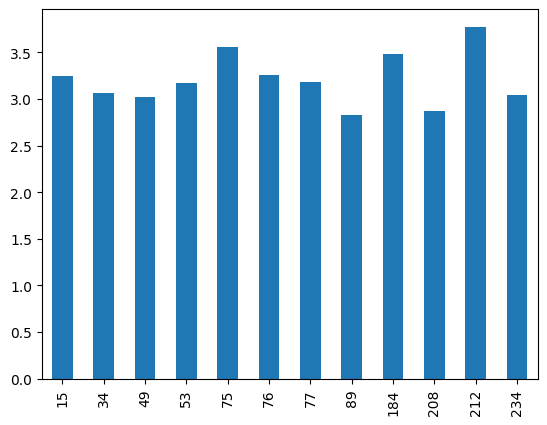

In [72]:
#Gráfica del promedio de goles de los equipos en la mejor liga
df_max["avg_goals"].plot(kind="bar")

<Axes: >

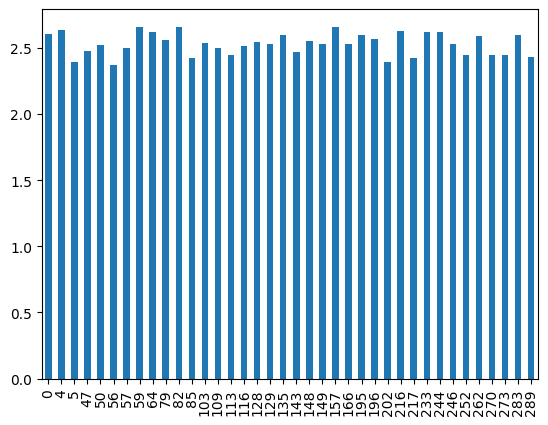

In [73]:
#Gráfica del promedio de goles de los equipos en la peor liga
df_min["avg_goals"].plot(kind="bar")

Promedio de los goles de diferencia

<Axes: >

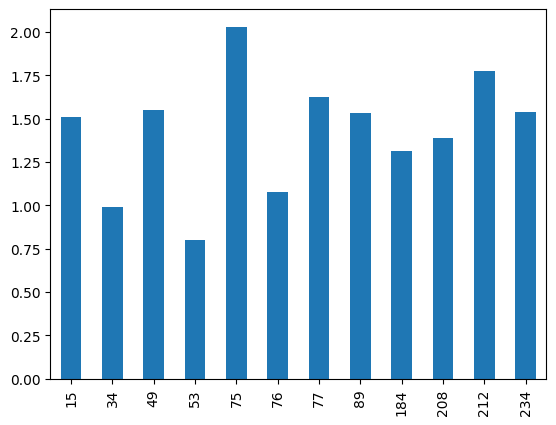

In [75]:
#Gráfica del promedio de goles de diferencia de  los equipos en la mejor liga
df_max["goal_difference_avg"].plot(kind="bar")

<Axes: >

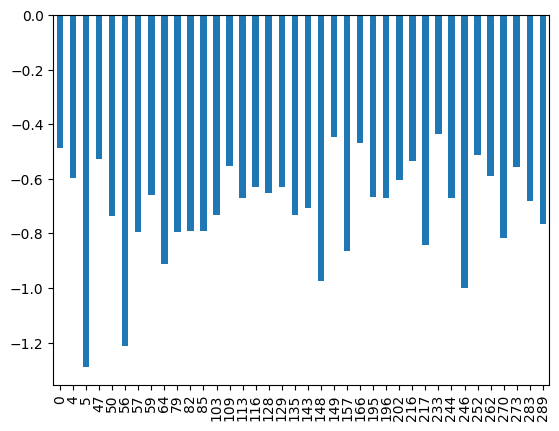

In [78]:
#Gráfica del promedio de goles de diferencia de  los equipos en la mejor liga
df_min["goal_difference_avg"].plot(kind="bar")

Porcentaje de victorias

<Axes: >

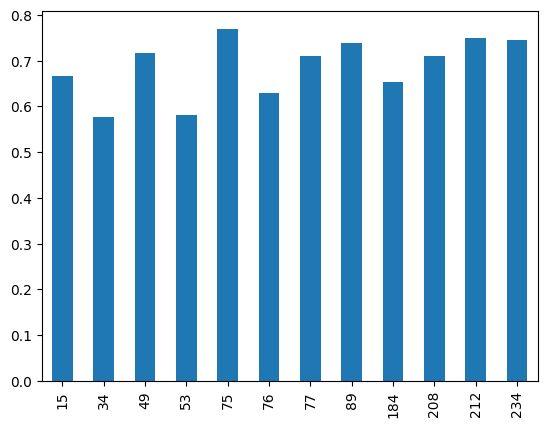

In [79]:
#Gráfica del porcentaje de victorias
df_max["win_percentage"].plot(kind="bar")

<Axes: >

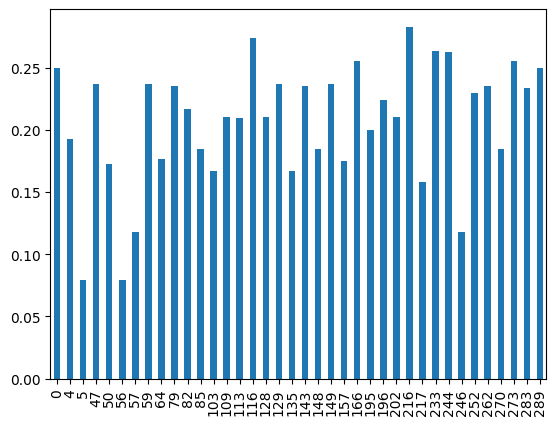

In [80]:
#Gráfica del porcentaje de victorias
df_min["win_percentage"].plot(kind="bar")

## Conclusiones

>**Instrucción.** Responda las siguientes cuestiones:
+ ¿Cuál es problema de aprendizaje automático que se solucionó? El agrupamiento de equipos de futbol en base a su rendimiento nos garantiza ligas más equilibradas y competitivas, esto evita que se repitan campeones.
+ ¿Qué datos se utilizaron? El data set de Kaggle llamado European Soccer Database
+ ¿Qué patrones importantes se encontraron en los datos? Nos dimos cuenta que varias características guardaban una alta correlación por lo que las eliminamos, también que el agrupamiento ideal según nuestro modelo no era formar 11 grupos (en este caso ligas) sin embargo para efectos prácticos mantuvimos el mismo número de grupos.
+ ¿Qué algoritmo y métrica de evaluación se utilizó en el modelo?
Usamos el k_means con criterio de paro agregado para los centroides, para la evaluación se hizo un análisis de los resultados del grupo con menor rendimiento vs el grupo con mejor rendimiento.
+ ¿Cómo se puede mejorar en el futuro?
Extender y actualizar los datos, agregar características importantes, actualizar los resultados del algoritmo por año o temporada en el fútbol y mejorar el análisis de los resultados, además de incorporar métricas más complejas de evaluación para este modelo.

### Referencias

> **Instrucción.** Agregar sus referencias bibliográficas en formato APA.

+ Mathien, H. (2016). European soccer database [Data set].


+ (S/f). Tibco.com. Recuperado el 2 de diciembre de 2023, de https://www.tibco.com/es/reference-center/what-is-unsupervised-learning

+ Ortega, C. (2022, febrero 21). Análisis estadístico: Qué es, usos y cómo realizarlo. QuestionPro. https://www.questionpro.com/blog/es/analisis-estadistico/



<br>
&copy; Edgar Moyotl-Hernández, 2023